NOTE: defining the HOME path constant

In [1]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


### Important ! Add "requirements.txt" file to working directory

In [3]:
# Installing required packages
!pip install -r {HOME}/requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 59.0 MB/s eta 0:00:00


### Connecting to Roboflow dataset

In [13]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [20]:
# Downloading dataset from Roboflow platform (Notice: after execution data will be deleted from google colab)
roboflow_project_name = 'stormdamagechallenge'
dataset_name = 'storm-damage'
dataset_title = 'Storm-Damage'
dataset_id = 'goe2a'
dataset_version = 8
model_name = 'yolo'
model_version = 'v8' # 'v8' or '11'
model_variant = 'n' # parameter required for model training phase

# Connect to roboflow dataset
rf = roboflow.Roboflow()
project = rf.workspace(roboflow_project_name).project(dataset_name + '-' + dataset_id)
dataset = project.version(dataset_version).download(model_name + model_version)

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to Storm-Damage-8 in yolov8:: 100%|██████████| 242/242 [00:00<00:00, 6183.54it/s]


### Import remaining packages

In [5]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Check the version of Ultralytics

In [6]:
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/112.6 GB disk)


In [7]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [8]:
!nvidia-smi

Mon Dec 23 19:58:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading YOLO model for Training


In [37]:
# Loading the model
model = YOLO(f'../models/{model_name + model_version}/{model_name + model_version + model_variant}.pt')
# Display model information (optional)
model.info()

YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

### Training Model

In [38]:
yaml_file = f'{HOME}/{dataset_title}-{dataset_version}/data.yaml'
yaml_file

'/content/Storm-Damage-8/data.yaml'

#### Resume model training from last step (optional)

In [ ]:
# Resuming model training from last completed epoch
# model = YOLO('last.pt')

In [39]:
# Define model training parameters
batch = 8 # set as an integer (e.g., batch=16), auto mode for 60% GPU memory utilization (batch=-1), or auto mode with specified utilization fraction (batch=0.70)
device = 0 # 0: GPU | 'cpu': cpu | 'mps': apple silicon mps
epochs = 50
patience = 10
imgsz = 640 # TODO: assess the importance of image size 640x640 by-design of Yolo models, image size role
plots = True
project = 'exploratory_phase' # parent directory name
name_train = f'{model_name + model_version + model_variant}_training_dataset_v{dataset_version}_' # run directory name

In [40]:
# Train the model
result_model_training = model.train(
                                    data=yaml_file,
                                    batch = batch,
                                    device = device,
                                    epochs = epochs,
                                    patience = patience,
                                    imgsz = imgsz,
                                    optimizer = 'AdamW',
                                    lr0 = 5e-4,
                                    momentum = 0.9,
                                    plots = plots,
                                    project = project,
                                    name = name_train
                                    )

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=../models/yolov8/yolov8n.pt, data=/content/Storm-Damage-8/data.yaml, epochs=50, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=exploratory_phase, name=yolov8n_training_dataset_v8_3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

train: Scanning /content/Storm-Damage-8/train/labels.cache... 81 images, 0 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Storm-Damage-8/valid/labels.cache... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<?, ?it/s]


Plotting labels to exploratory_phase/yolov8n_training_dataset_v8_3/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to exploratory_phase/yolov8n_training_dataset_v8_3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.51G       1.97      3.554      1.584          6        640: 100%|██████████| 11/11 [00:04<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         22        526    0.00341      0.192    0.00287   0.000889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.49G      1.789       2.49      1.365         38        640: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         22        526     0.0273      0.441      0.173     0.0644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       1.4G      1.702          2      1.315         48        640: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         22        526     0.0837      0.471      0.235      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.48G       1.64      1.917      1.292         21        640: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         22        526     0.0537      0.692      0.328      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.41G      1.706      1.727      1.325         85        640: 100%|██████████| 11/11 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

                   all         22        526     0.0588      0.776       0.44      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       1.5G      1.635      1.828      1.333         12        640: 100%|██████████| 11/11 [00:01<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         22        526      0.521      0.441      0.444       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.65G      1.657      1.659      1.282         13        640: 100%|██████████| 11/11 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

                   all         22        526      0.677      0.252      0.425      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.36G      1.703      2.113      1.393          3        640: 100%|██████████| 11/11 [00:01<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

                   all         22        526      0.662      0.307      0.424      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.47G       1.66       1.62      1.318         37        640: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         22        526      0.584      0.405      0.458       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.57G      1.648      1.822      1.295          7        640: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         22        526      0.552      0.468      0.489      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.48G      1.617      1.544      1.291         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         22        526      0.575      0.496      0.512      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.37G      1.629      1.512      1.279         16        640: 100%|██████████| 11/11 [00:01<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         22        526      0.652      0.456       0.49      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.43G      1.627      1.518       1.28         13        640: 100%|██████████| 11/11 [00:01<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         22        526      0.669      0.485      0.516      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.44G      1.533      1.568      1.246          9        640: 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         22        526      0.675      0.508      0.572       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.55G      1.592      1.439      1.243         13        640: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         22        526      0.662      0.527      0.584      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.41G      1.555       1.45      1.242         11        640: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         22        526       0.65      0.522      0.576      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.37G      1.593       1.99      1.348          2        640: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         22        526      0.647      0.529      0.573      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       1.5G      1.592      1.408      1.258         59        640: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         22        526       0.63      0.539      0.581      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.48G      1.561      1.407      1.266         42        640: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         22        526      0.649      0.537       0.59      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.41G      1.531      1.526      1.283          5        640: 100%|██████████| 11/11 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         22        526      0.675      0.552      0.607      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.44G      1.523      1.415      1.235          8        640: 100%|██████████| 11/11 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

                   all         22        526      0.579      0.583      0.608      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.31G      1.562      1.313      1.221         92        640: 100%|██████████| 11/11 [00:01<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

                   all         22        526      0.742      0.499      0.605      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.57G      1.476      1.463      1.194          5        640: 100%|██████████| 11/11 [00:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         22        526      0.665      0.501       0.59      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.65G      1.577      1.469      1.288         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         22        526      0.575      0.564      0.584      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.42G      1.555      1.272      1.197         54        640: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         22        526      0.624      0.543      0.591      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.29G      1.529      1.357      1.241         65        640: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

                   all         22        526      0.668      0.538      0.586      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.34G      1.559      1.288      1.183         20        640: 100%|██████████| 11/11 [00:01<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         22        526       0.69      0.522      0.573      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.49G      1.564      1.376      1.225         46        640: 100%|██████████| 11/11 [00:01<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         22        526      0.705      0.538      0.543      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.48G      1.566      1.295      1.232         27        640: 100%|██████████| 11/11 [00:01<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


                   all         22        526      0.698      0.524      0.564      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.32G      1.529      1.365      1.253         17        640: 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         22        526      0.768      0.525      0.579      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.36G      1.552       1.35      1.243          5        640: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         22        526      0.699      0.544       0.58      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.54G      1.522      1.263      1.206         66        640: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         22        526      0.743       0.51      0.577      0.297
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 22, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



32 epochs completed in 0.037 hours.
Optimizer stripped from exploratory_phase/yolov8n_training_dataset_v8_3/weights/last.pt, 6.2MB
Optimizer stripped from exploratory_phase/yolov8n_training_dataset_v8_3/weights/best.pt, 6.2MB

Validating exploratory_phase/yolov8n_training_dataset_v8_3/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


                   all         22        526      0.743      0.499      0.604      0.318
undamagedcommercialbuilding         15        117      0.802      0.208      0.419      0.234
undamagedresidentialbuilding         14        409      0.683       0.79       0.79      0.403
Speed: 0.3ms preprocess, 4.4ms inference, 0.0ms loss, 19.2ms postprocess per image
Results saved to exploratory_phase/yolov8n_training_dataset_v8_3


In [41]:
result_model_training

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e8b8d6d6650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

### Conclusion
* Seems that we reached the maximum plateau of mAP performance with the given data. We reached a 0.79 mAP50 for undamagedresidentialbuidlings and a much smaller 0.41 mAP50 for undamagedcommercialbuildings. This is most probably related to the very strong disbalance between the two classes 1919 vs 342. which is a 5.6 times ! We need to further improve the disbalance

In [45]:
1919 / 342

5.611111111111111

#### Dataset version 8 (run3):
- Key feature: 0 train background images / 0 val background images
- batch = 8
- optimizer = 'AdamW'
- lr = 0.0005 (Auto)
- momentum = 0.9 <br>
Results:
- mAP50 =  0.6044954593433212
- mAP50-95 = 0.3184200414080874

/content


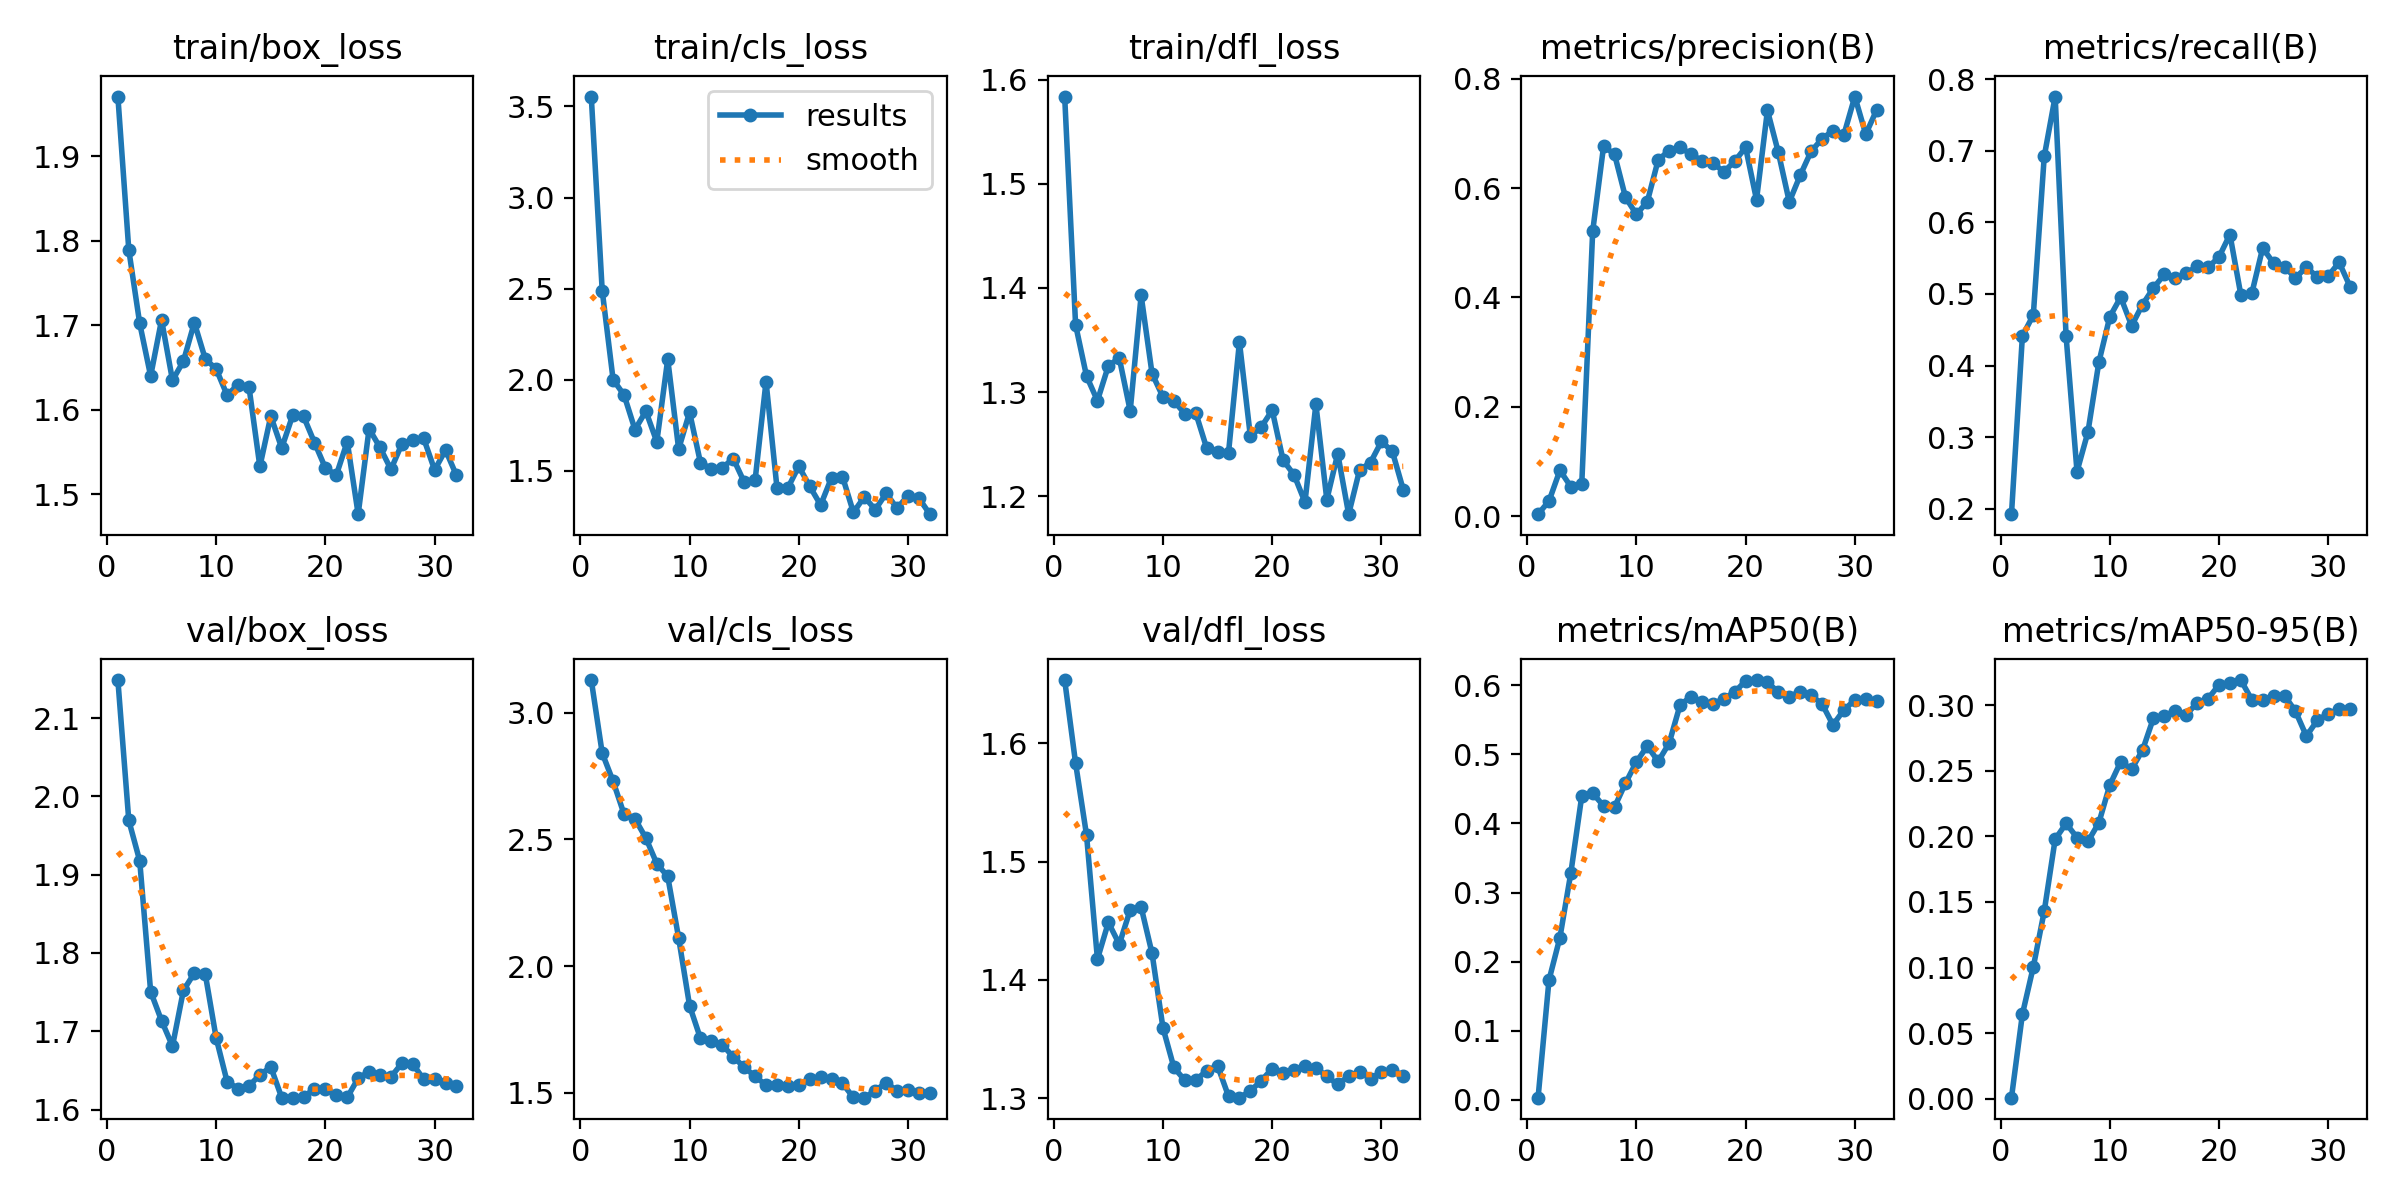

In [42]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}3/results.png', width=600)

/content


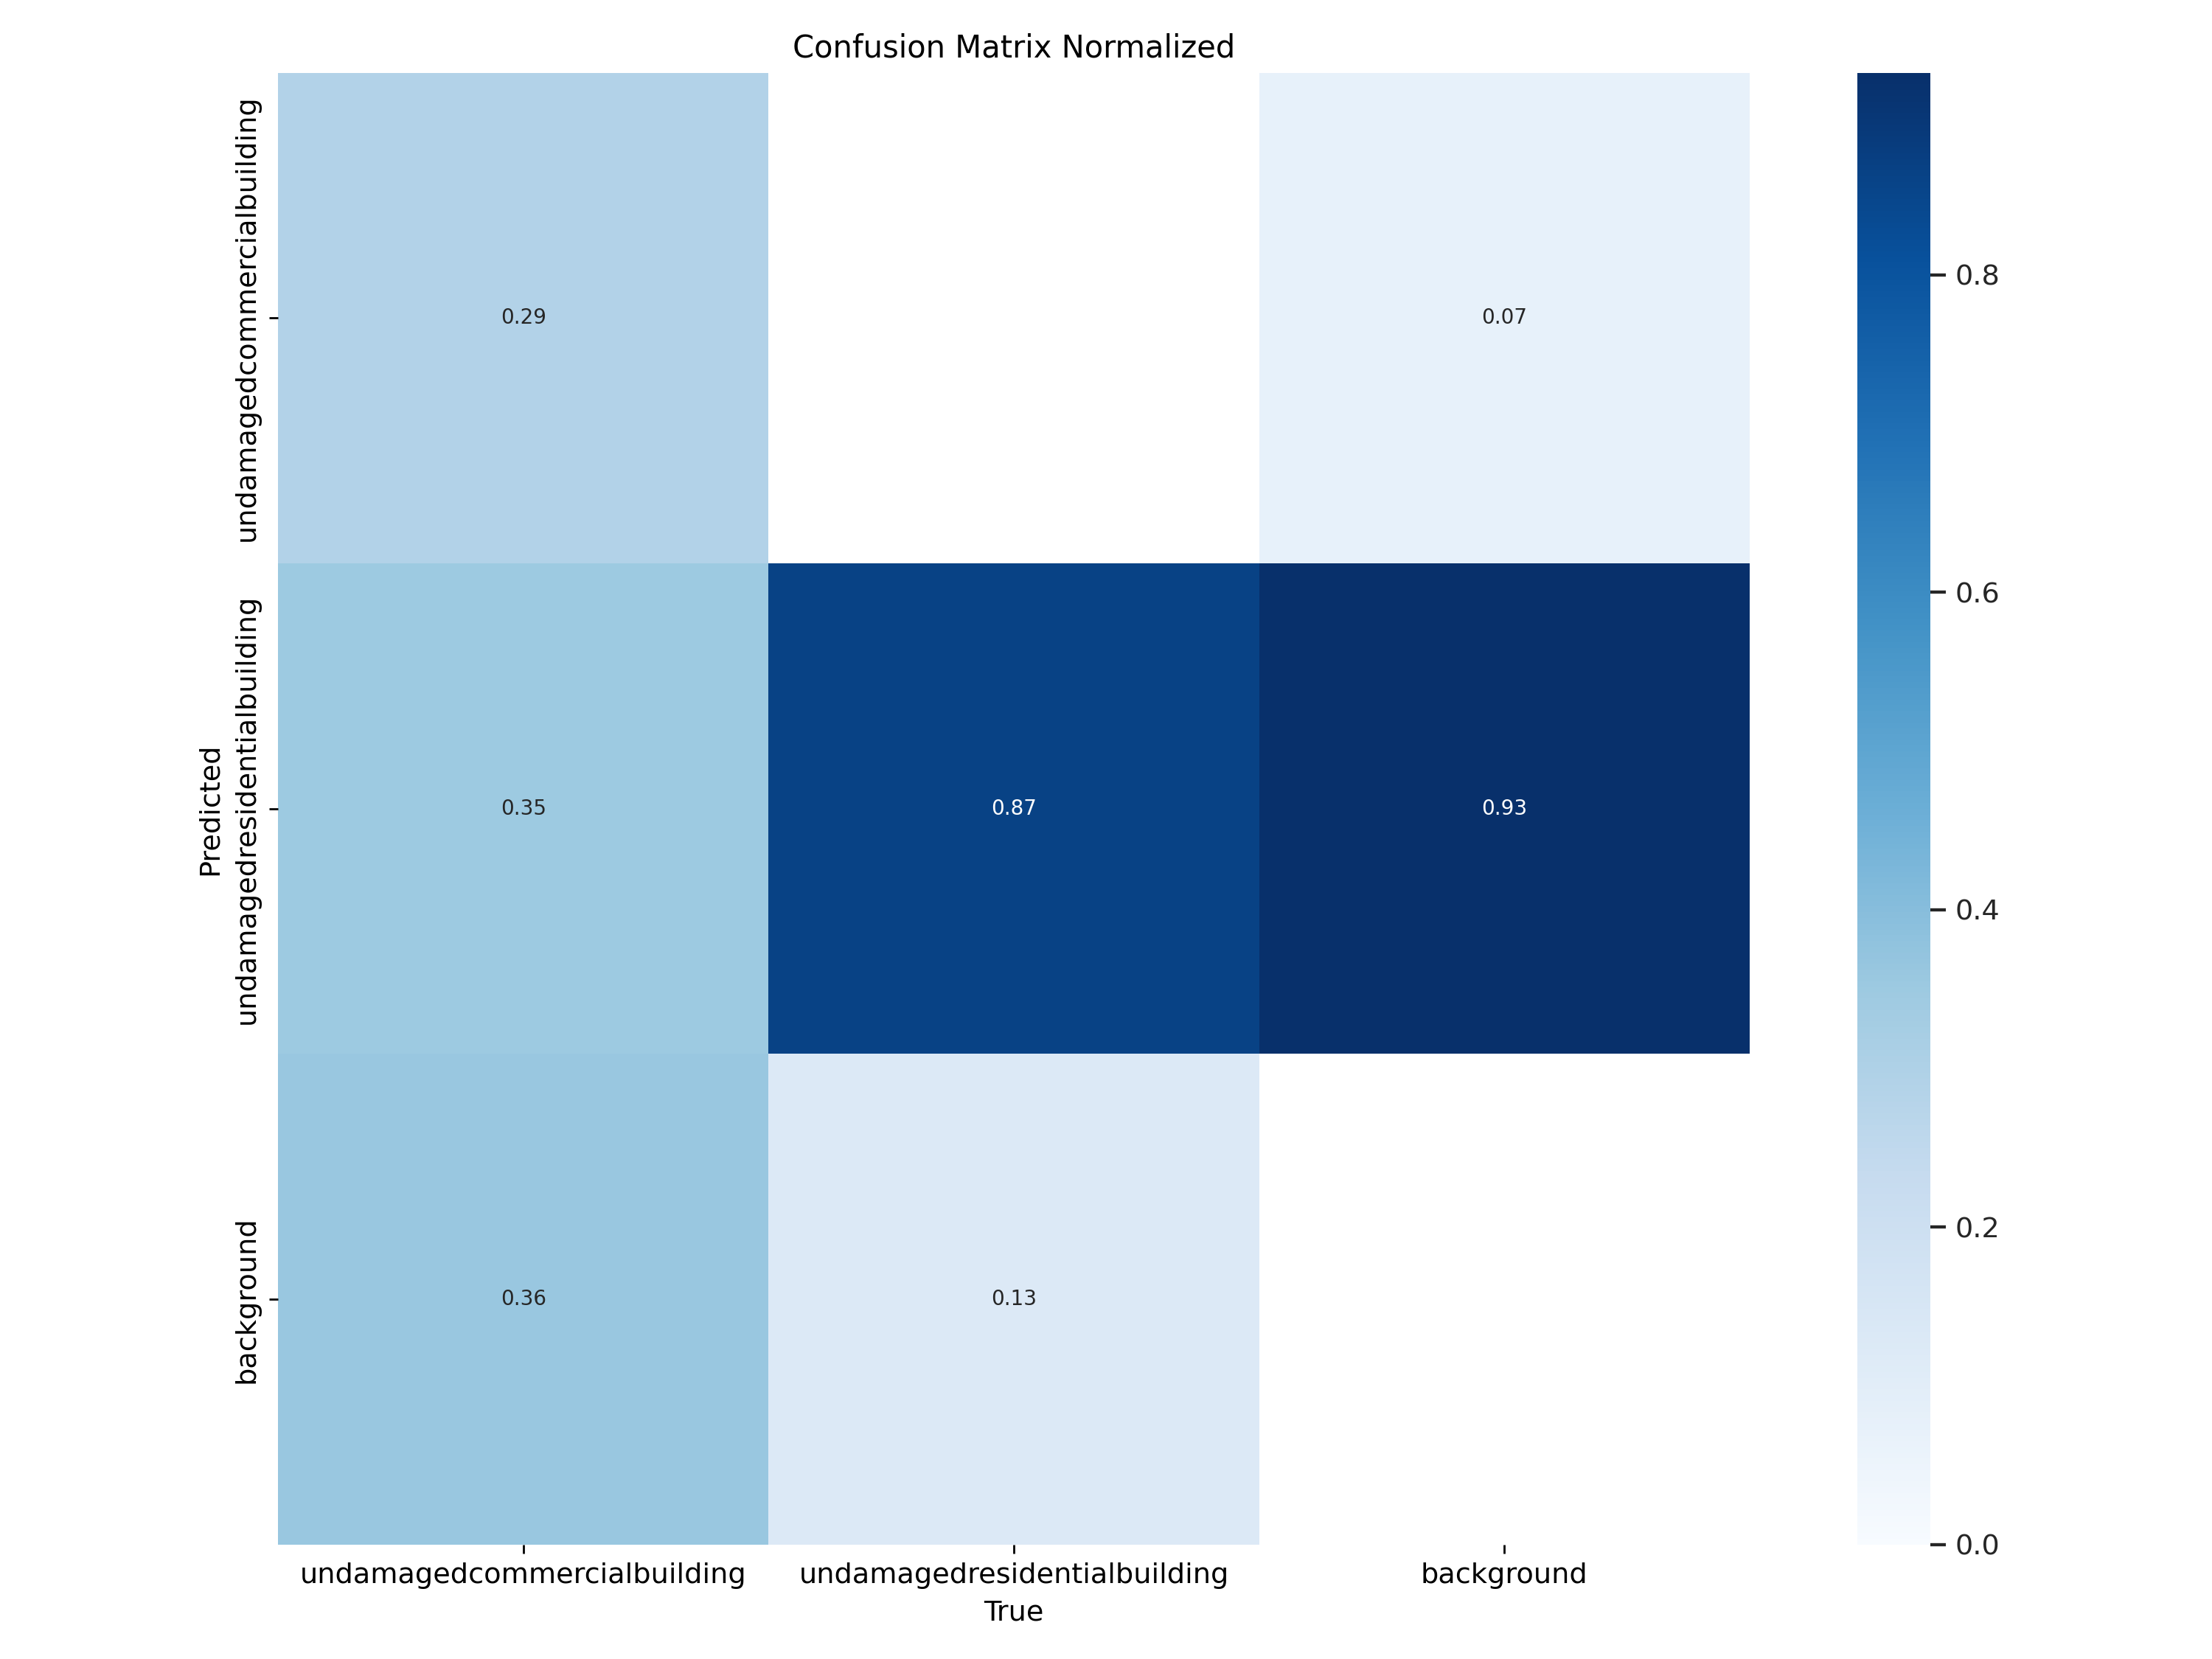

In [43]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}3/confusion_matrix_normalized.png', width=600)

#### Dataset version 8 (run2):
- Key feature: 0 train background images / 0 val background images
- batch = 16
- optimizer = 'AdamW'
- lr = 0.00166667 (Auto)
- momentum = 0.9 <br>
Results:
- mAP50 =  0.6181538620004919
- mAP50-95 = 0.32041948479090815

/content


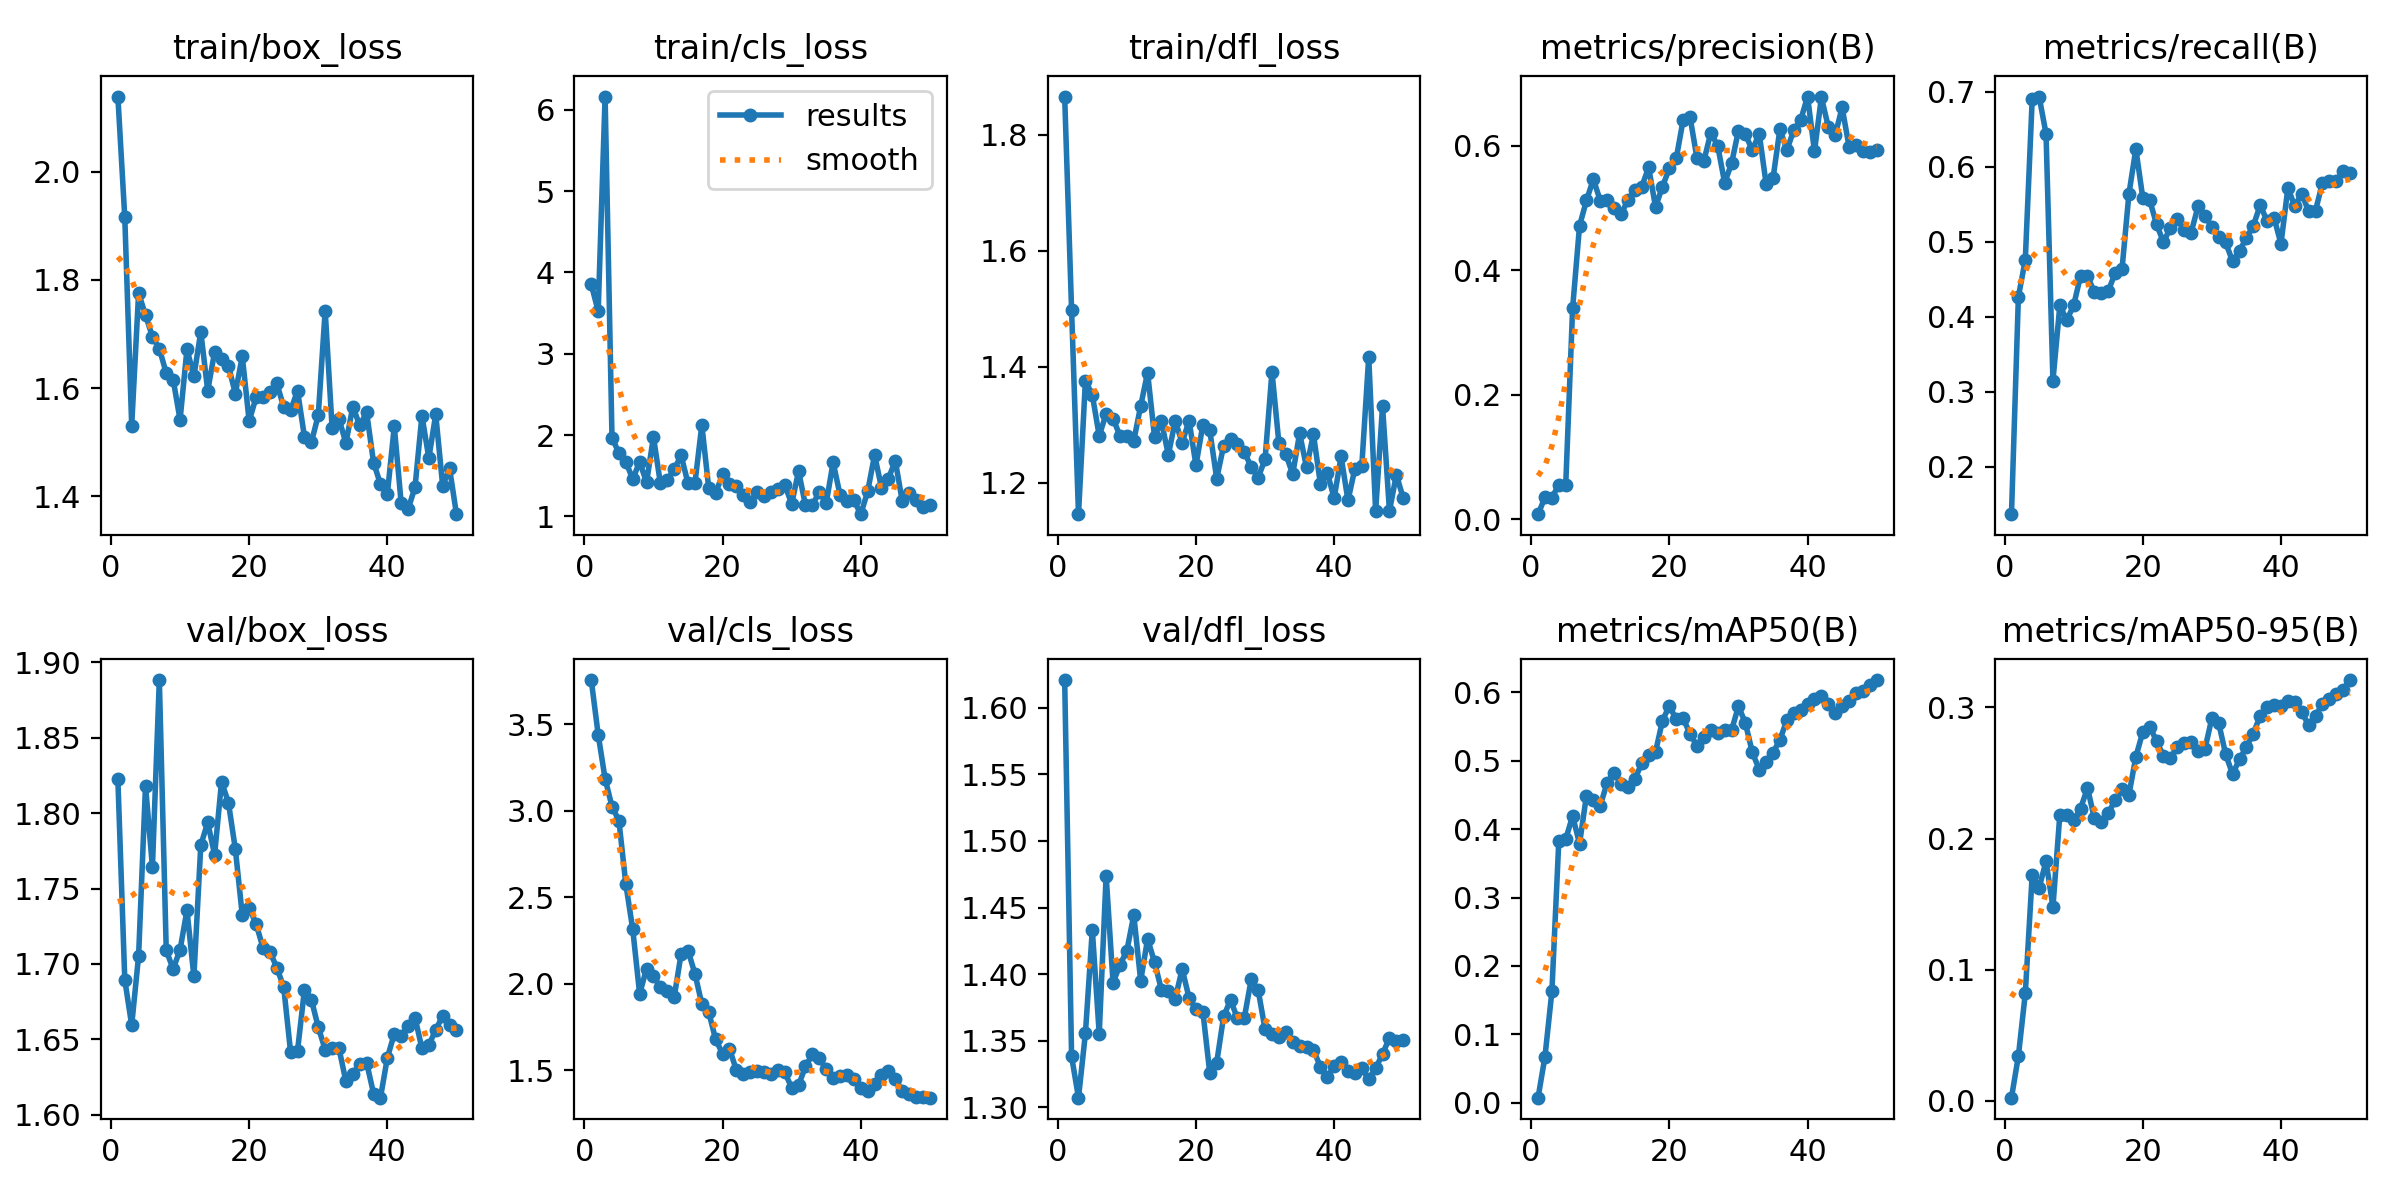

In [35]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}2/results.png', width=600)

/content


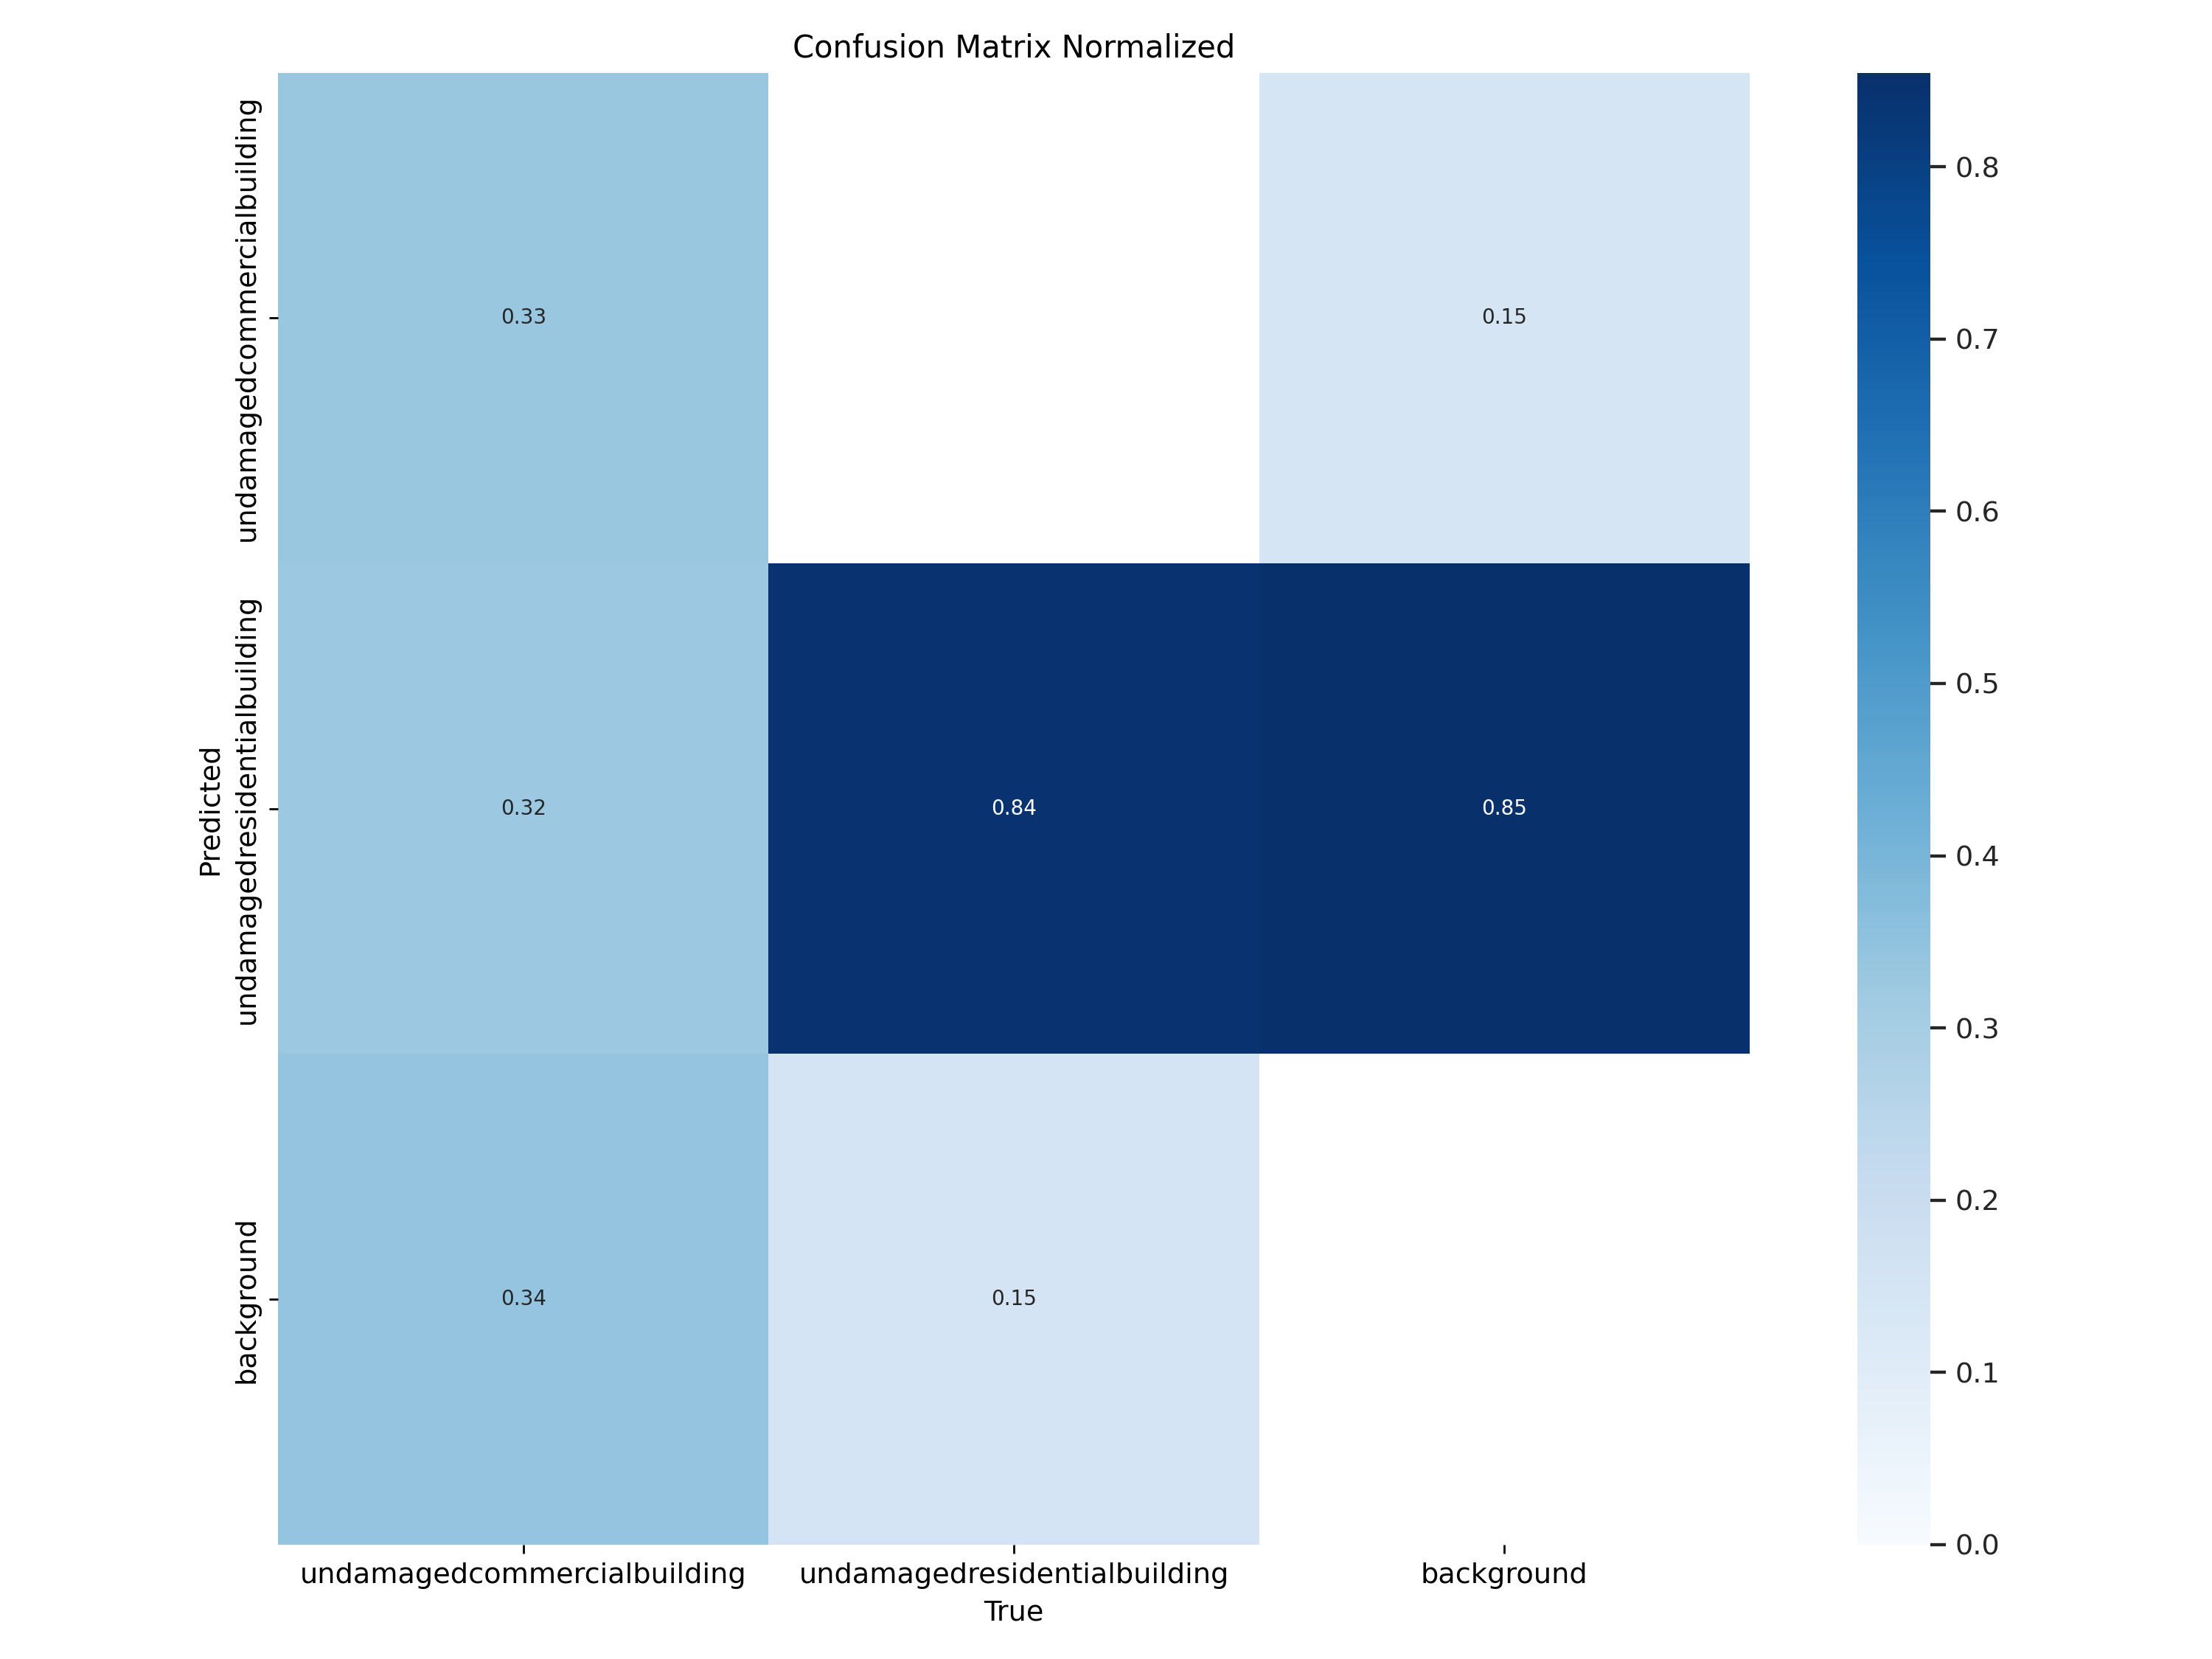

In [36]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}2/confusion_matrix_normalized.png', width=600)

#### Dataset version 8:
- Key feature: 0 train background images / 0 val background images
- batch = 16
- optimizer = 'AdamW'
- lr = 5e-4
- momentum = 0.9 <br>
Results:
- mAP50 =  0.6205392625767654
- mAP50-95 = 0.32100097657800297

/content


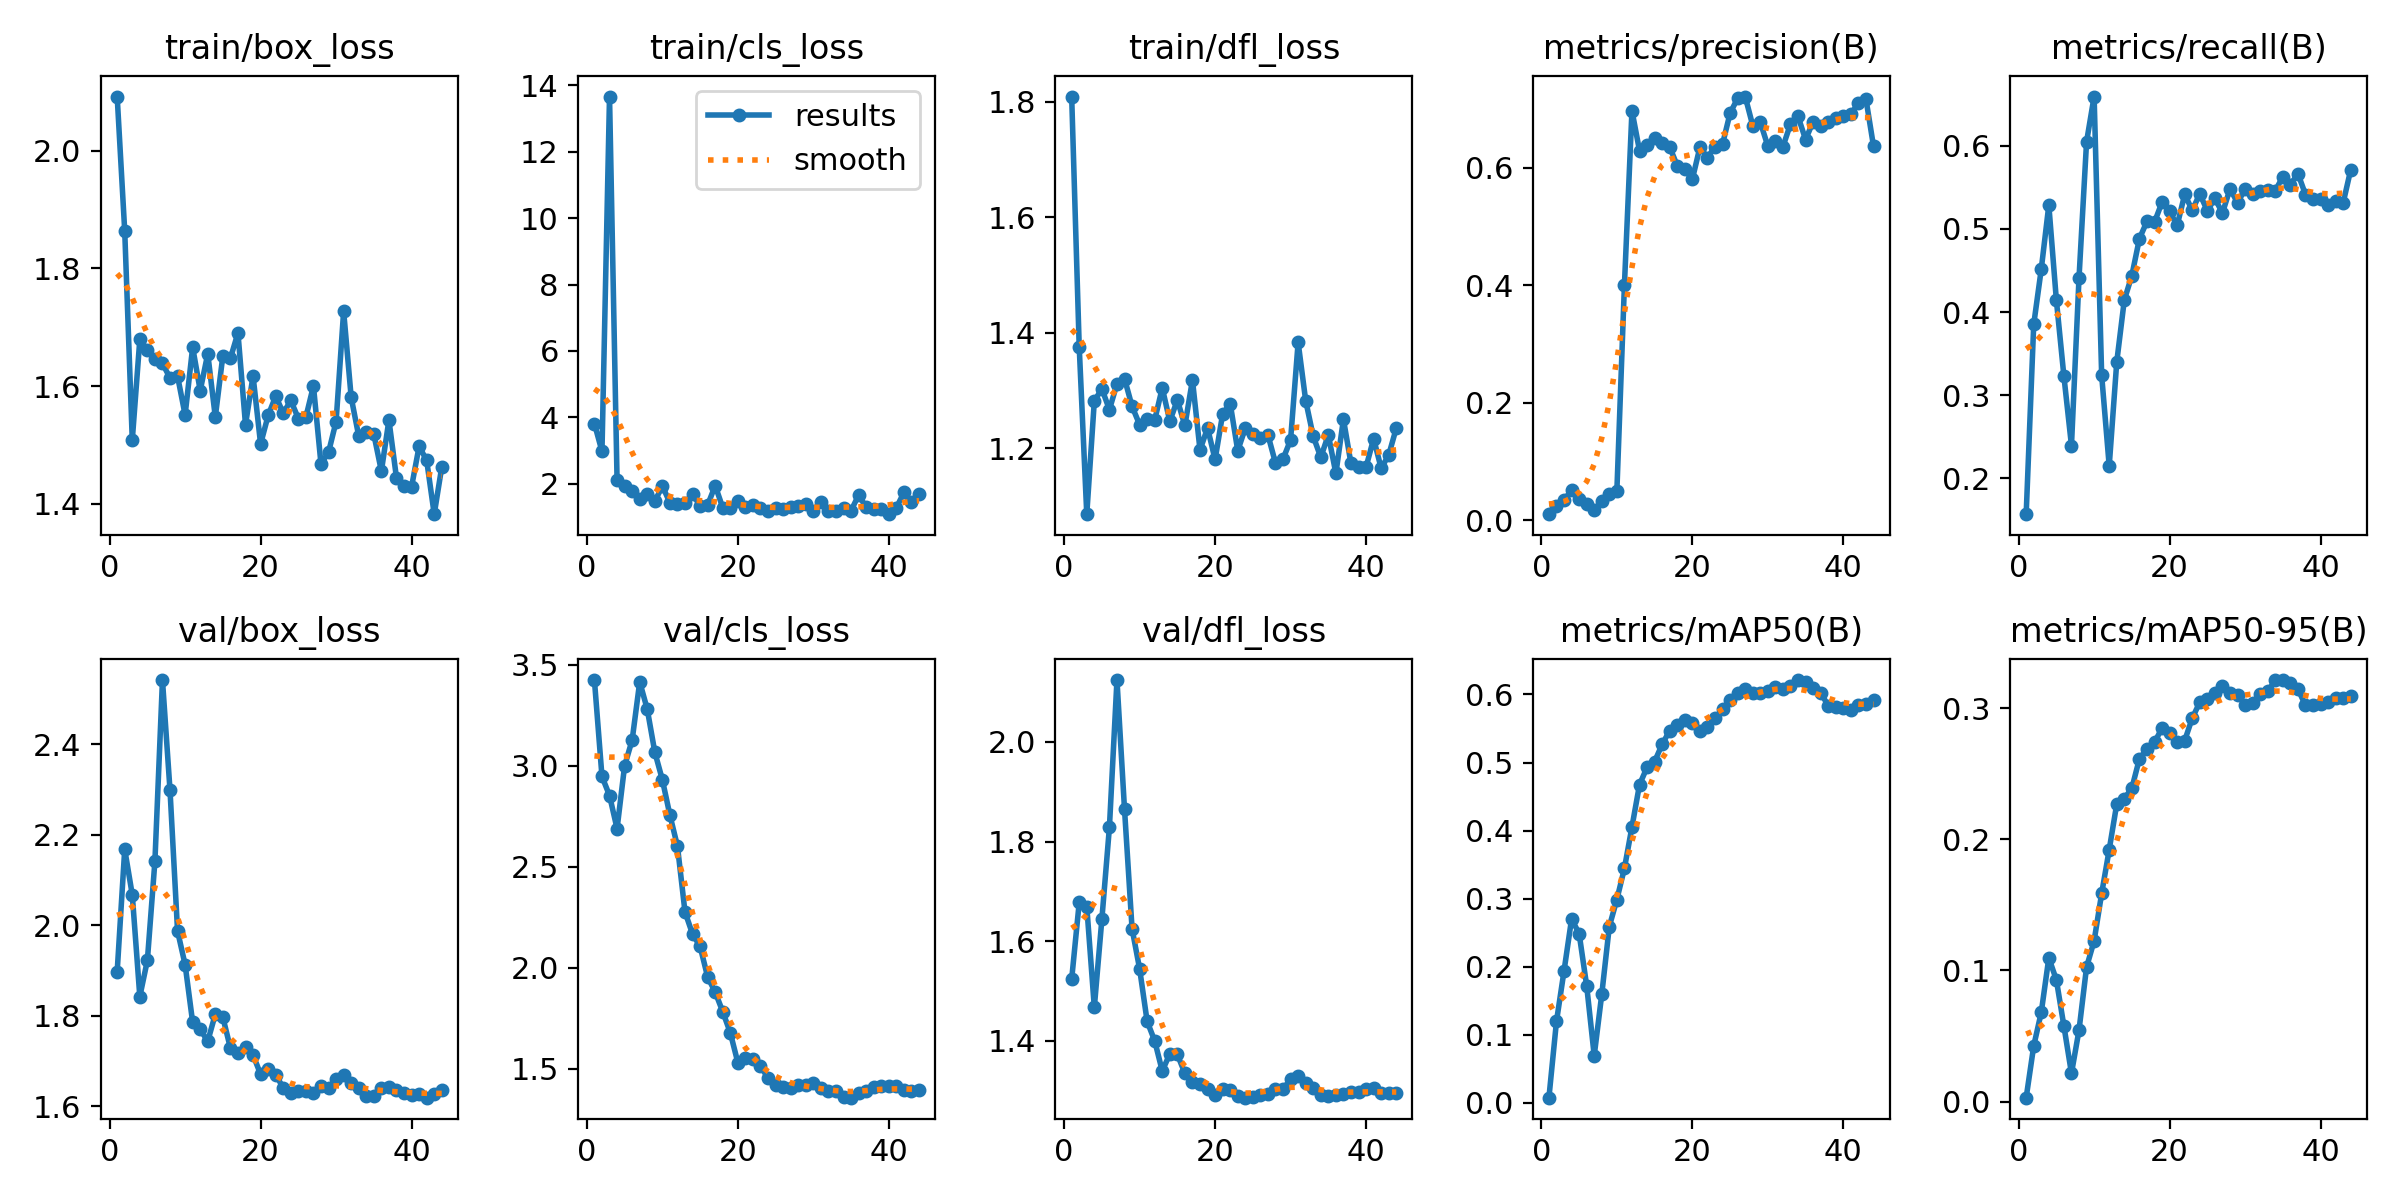

In [27]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/results.png', width=600)

/content


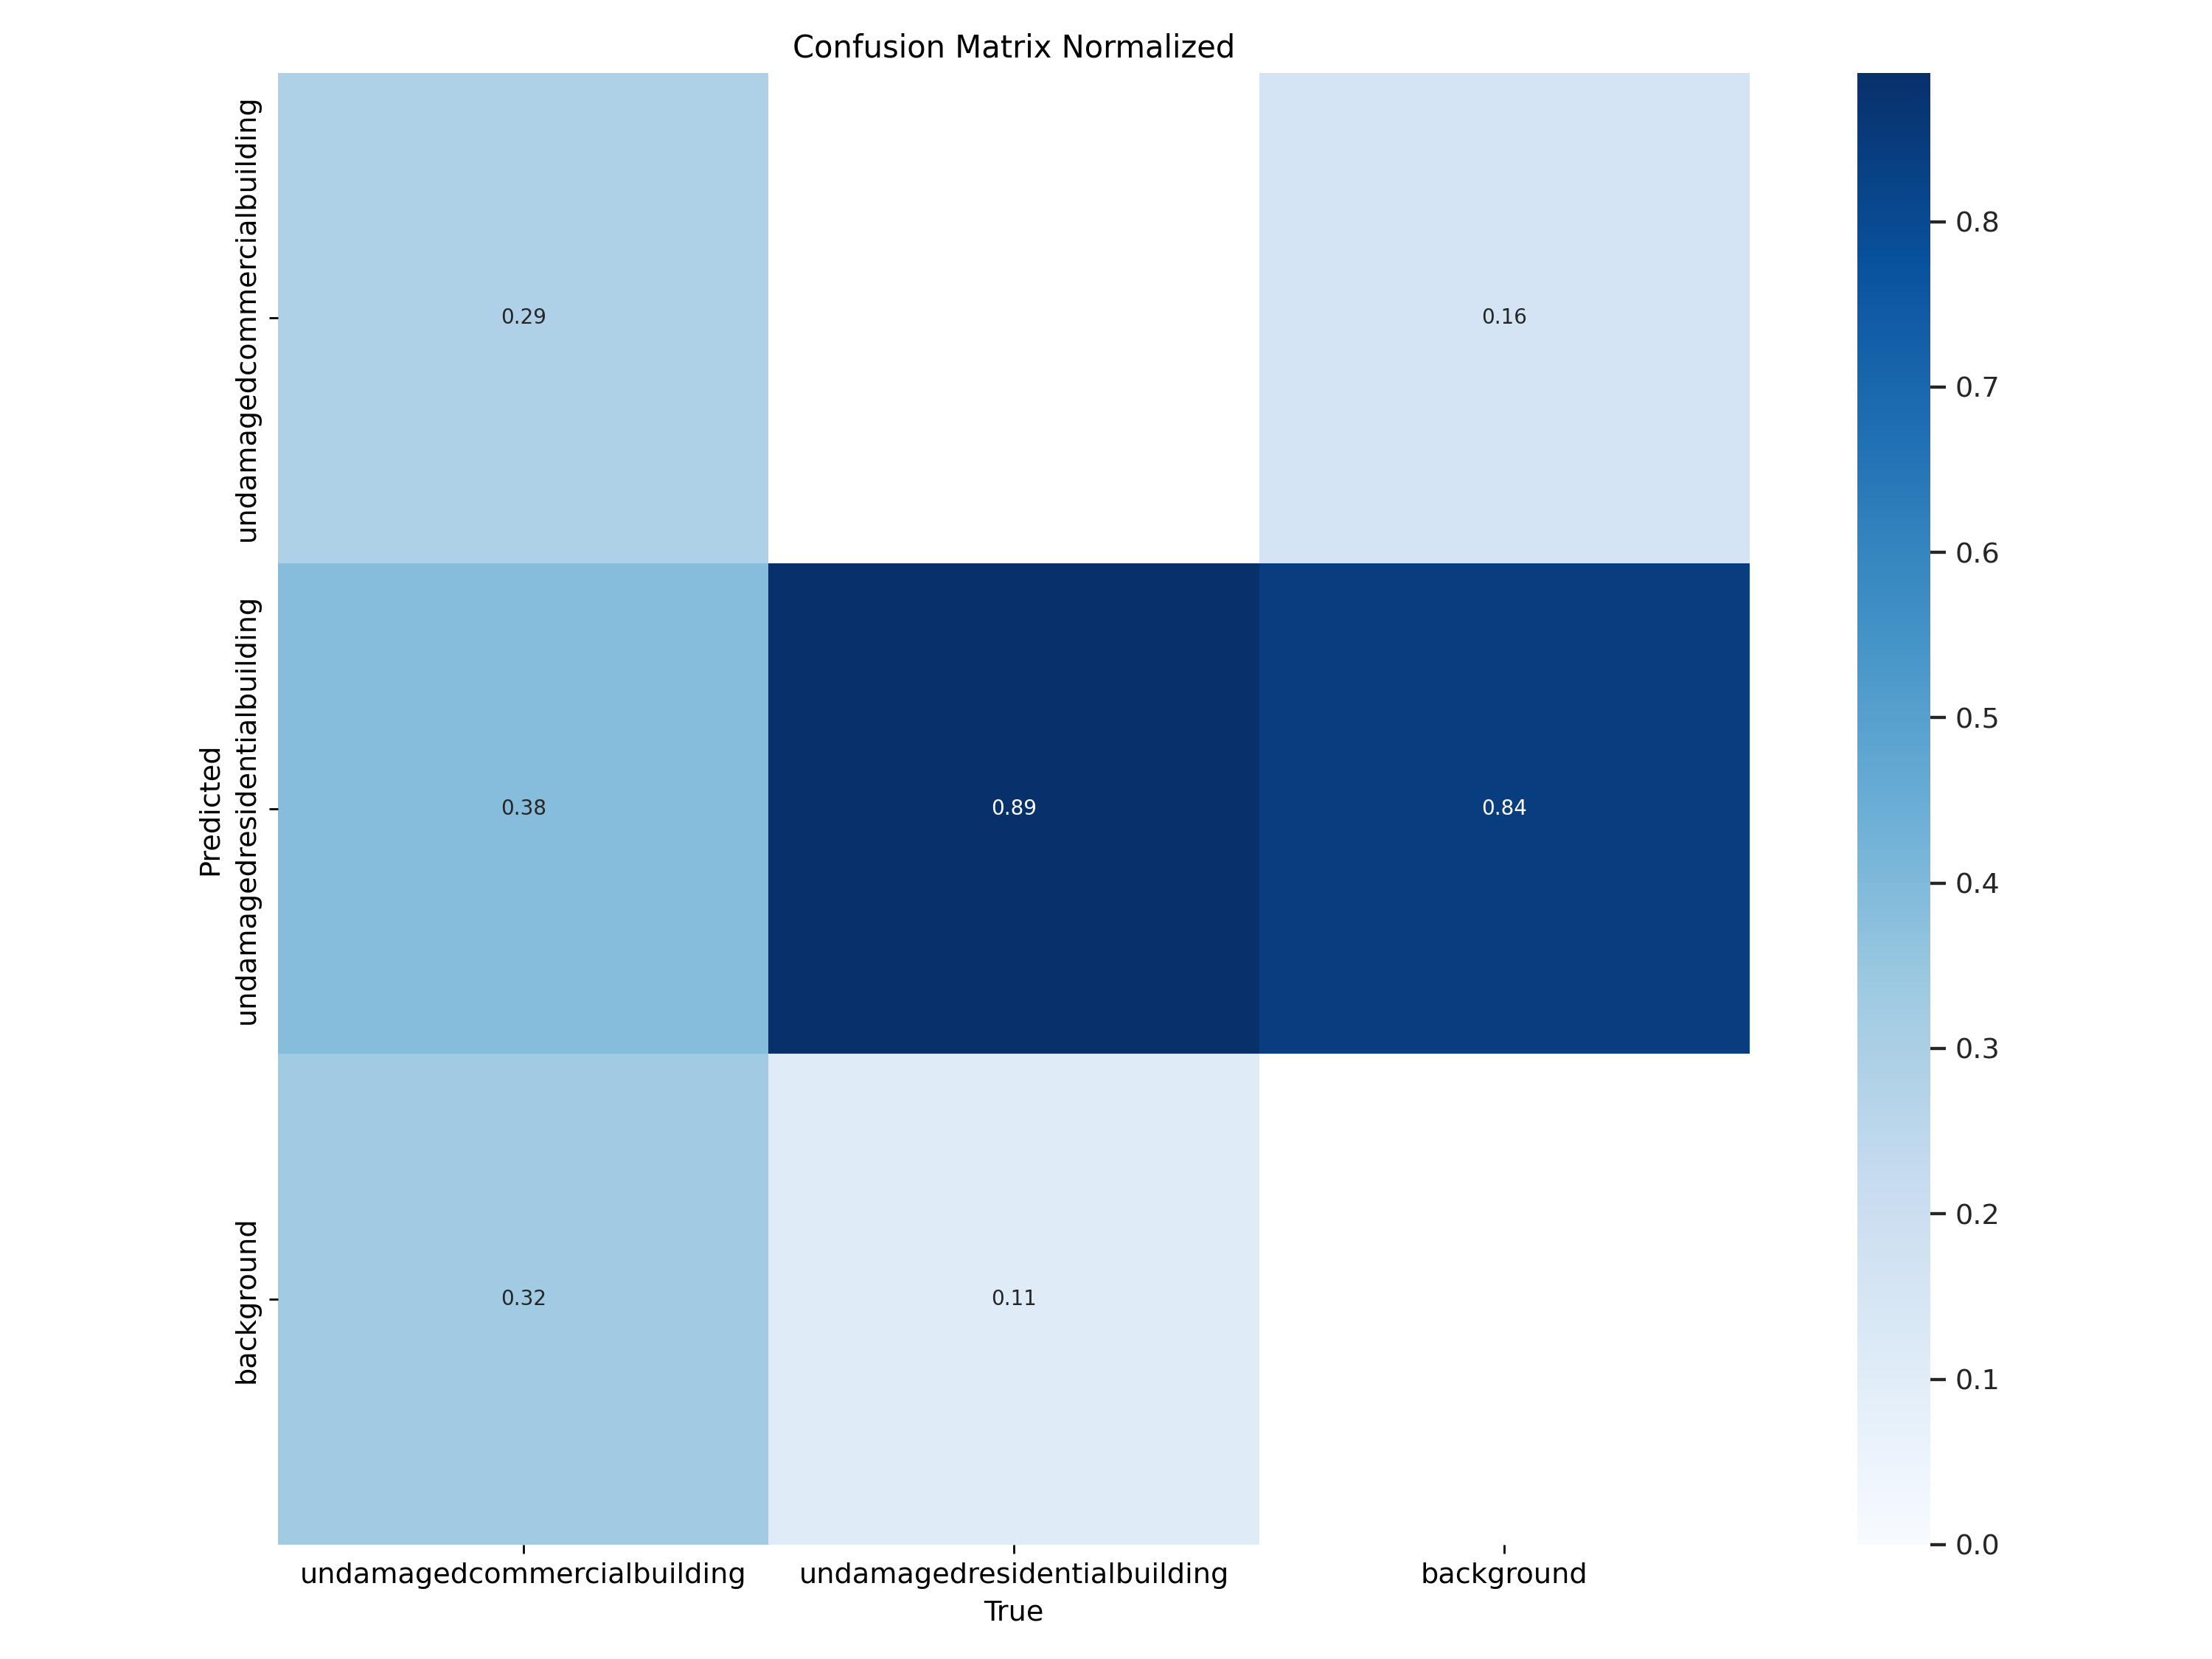

In [29]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/confusion_matrix_normalized.png', width=600)

#### Dataset version 7:
- Key feature: 15 train background images / 3 val background images
- batch = 16
- optimizer = 'AdamW'
- lr = 5e-4
- momentum = 0.9 <br>
Results:
- mAP50 =  0.6049396402638334
- mAP50-95 = 0.30803287301836724


/content


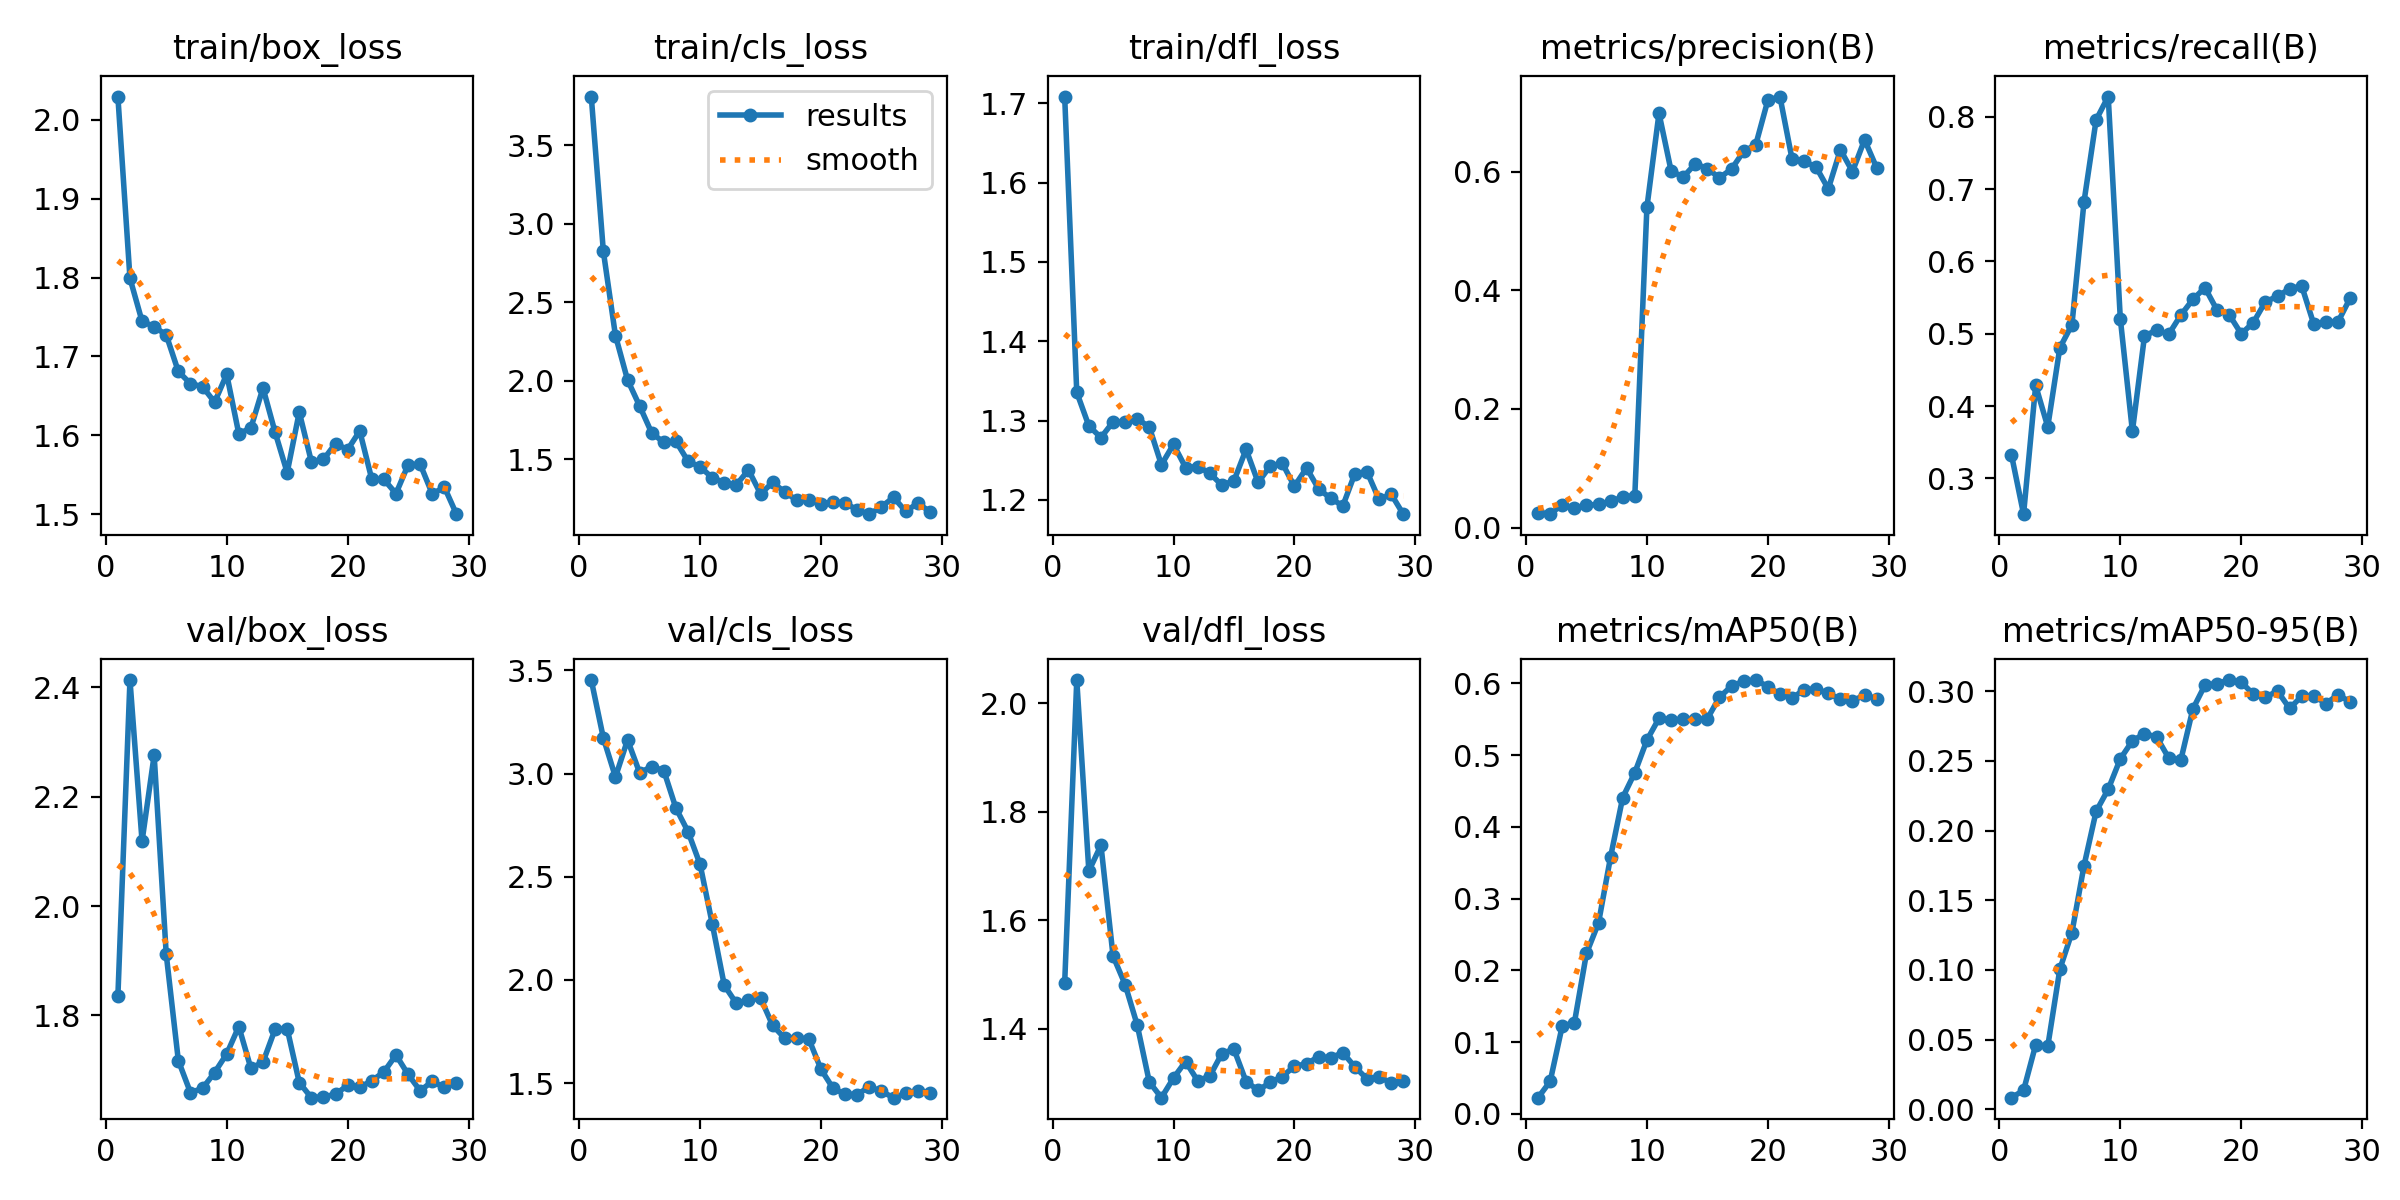

In [18]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}2/results.png', width=600)

/content


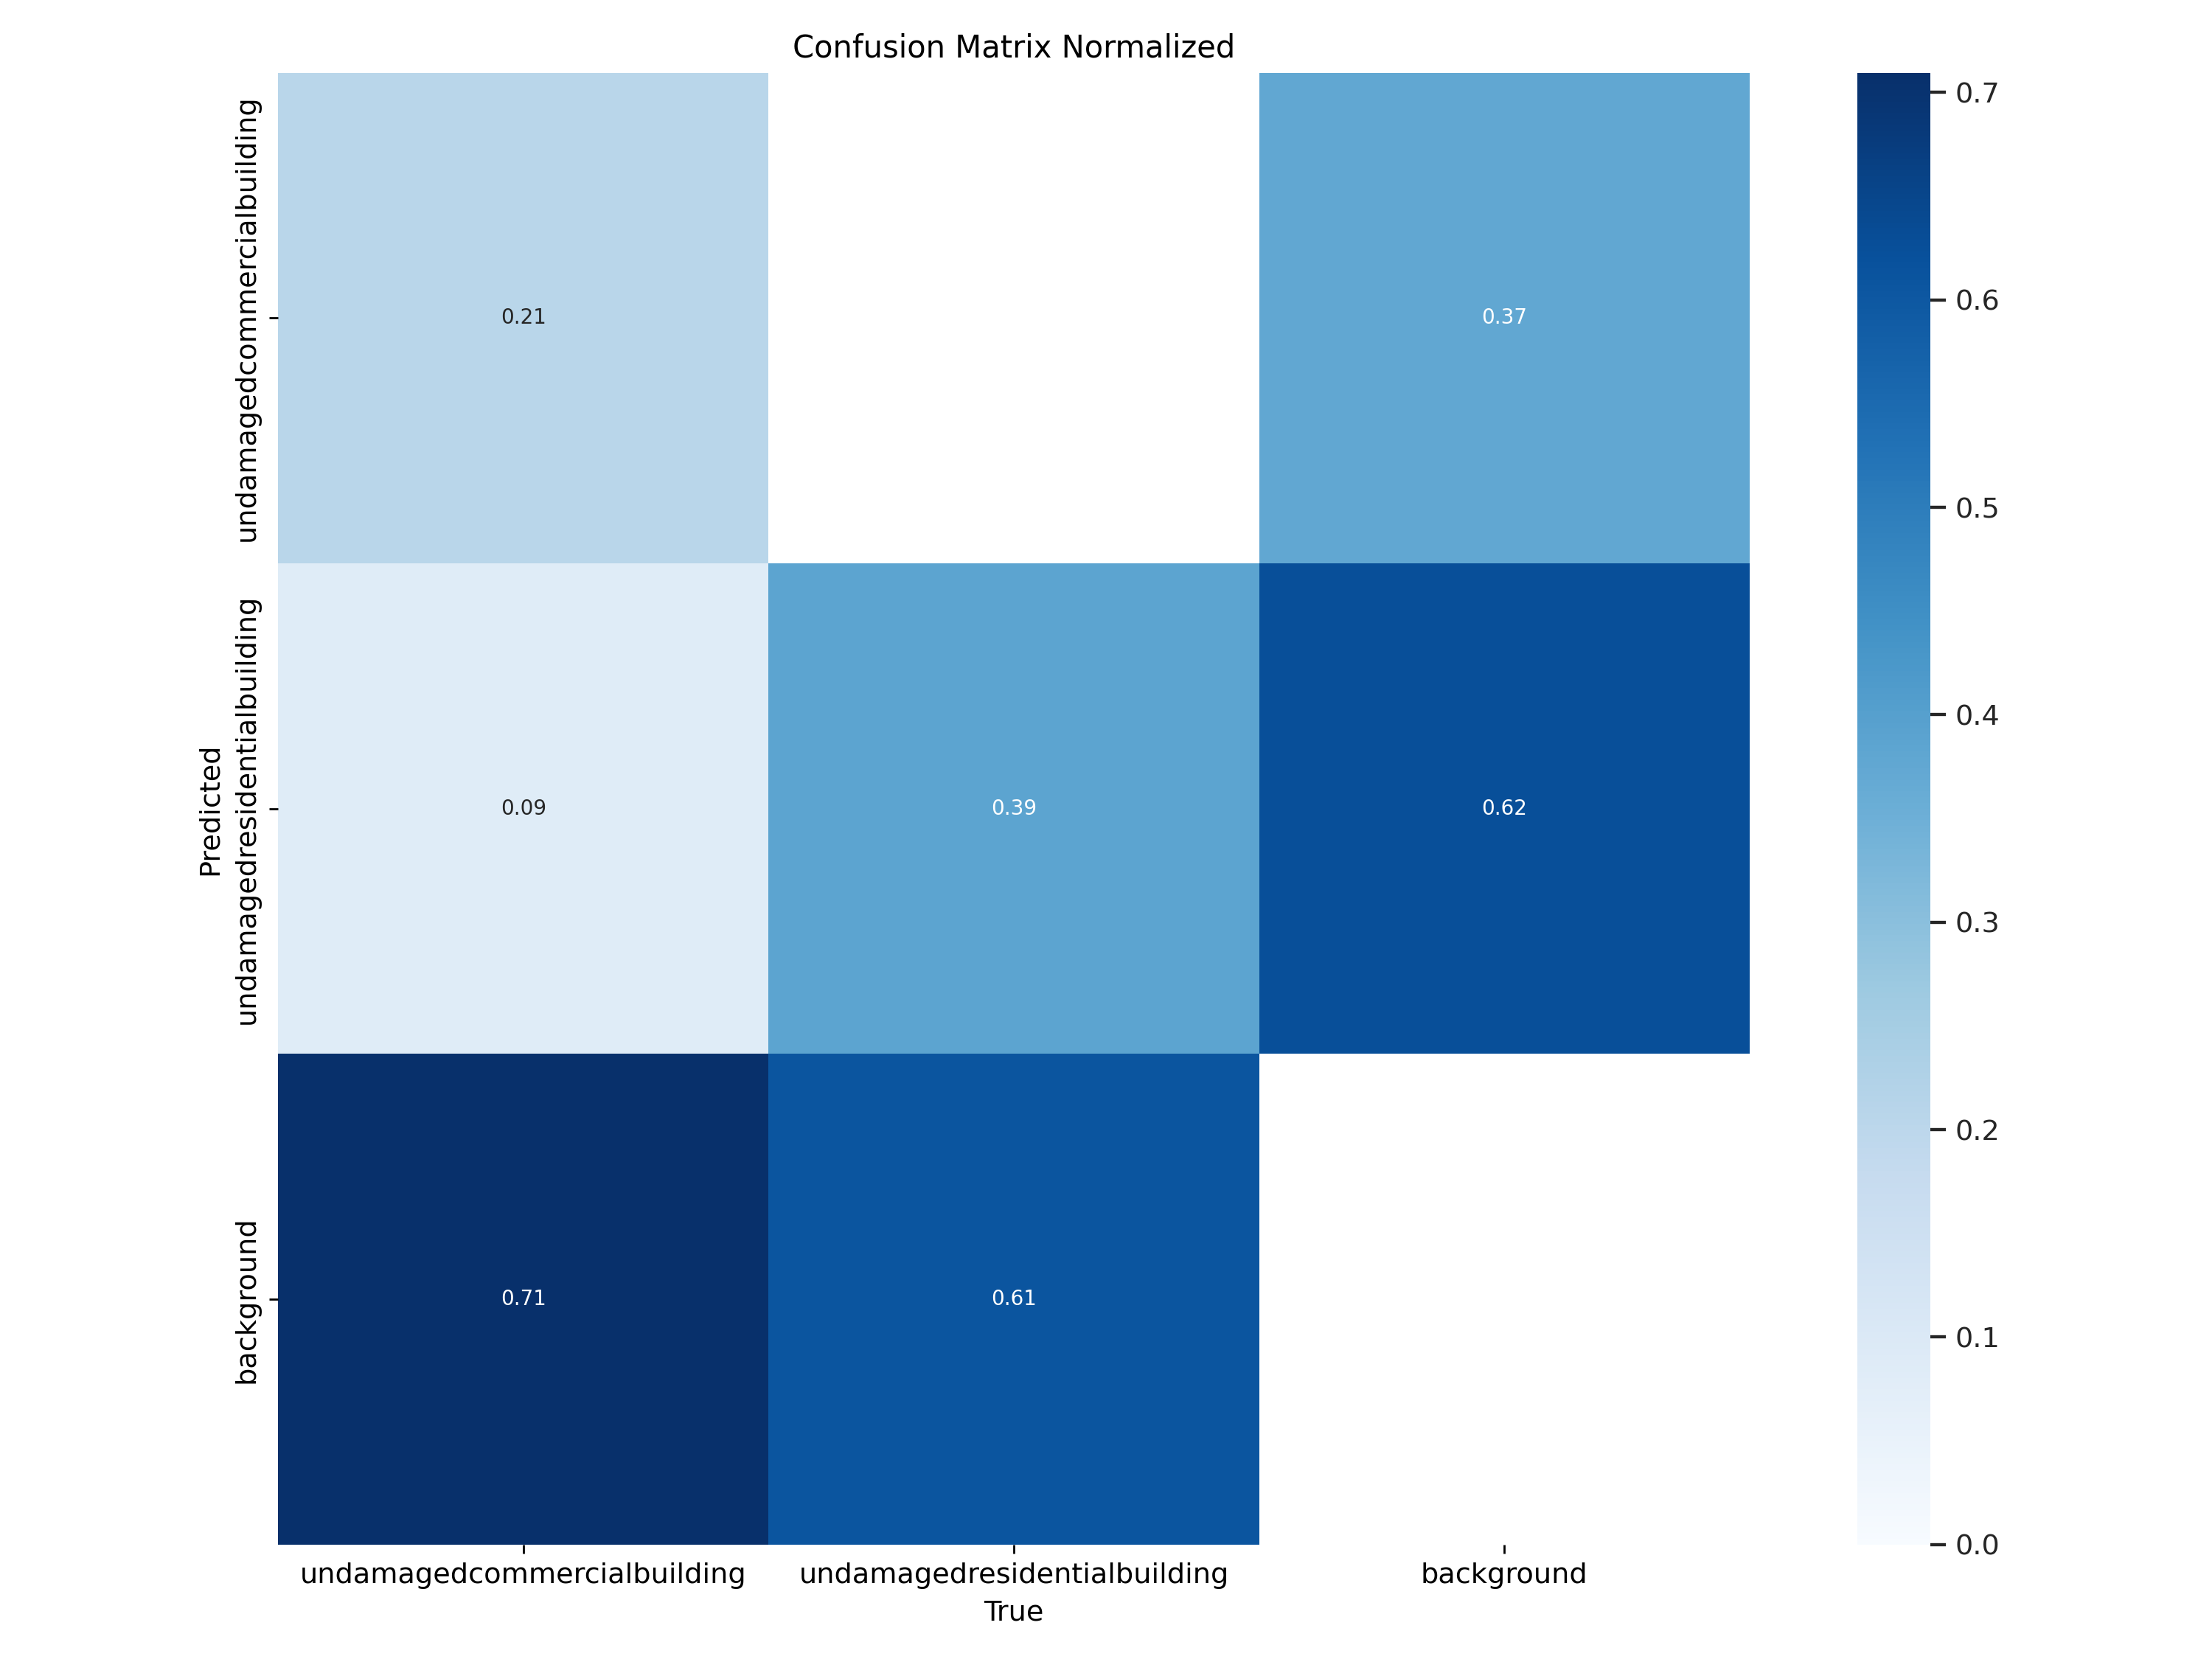

In [19]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}2/confusion_matrix_normalized.png', width=600)

### Dataset version 6:
Main characteristics: NO data augmentation on roboflow
batch = 16
lr0 = 5e-4,
momentum = 0.9,
'metrics/mAP50(B)': 0.6839908355613613, 'metrics/mAP50-95(B)': 0.3526908468255653

/content


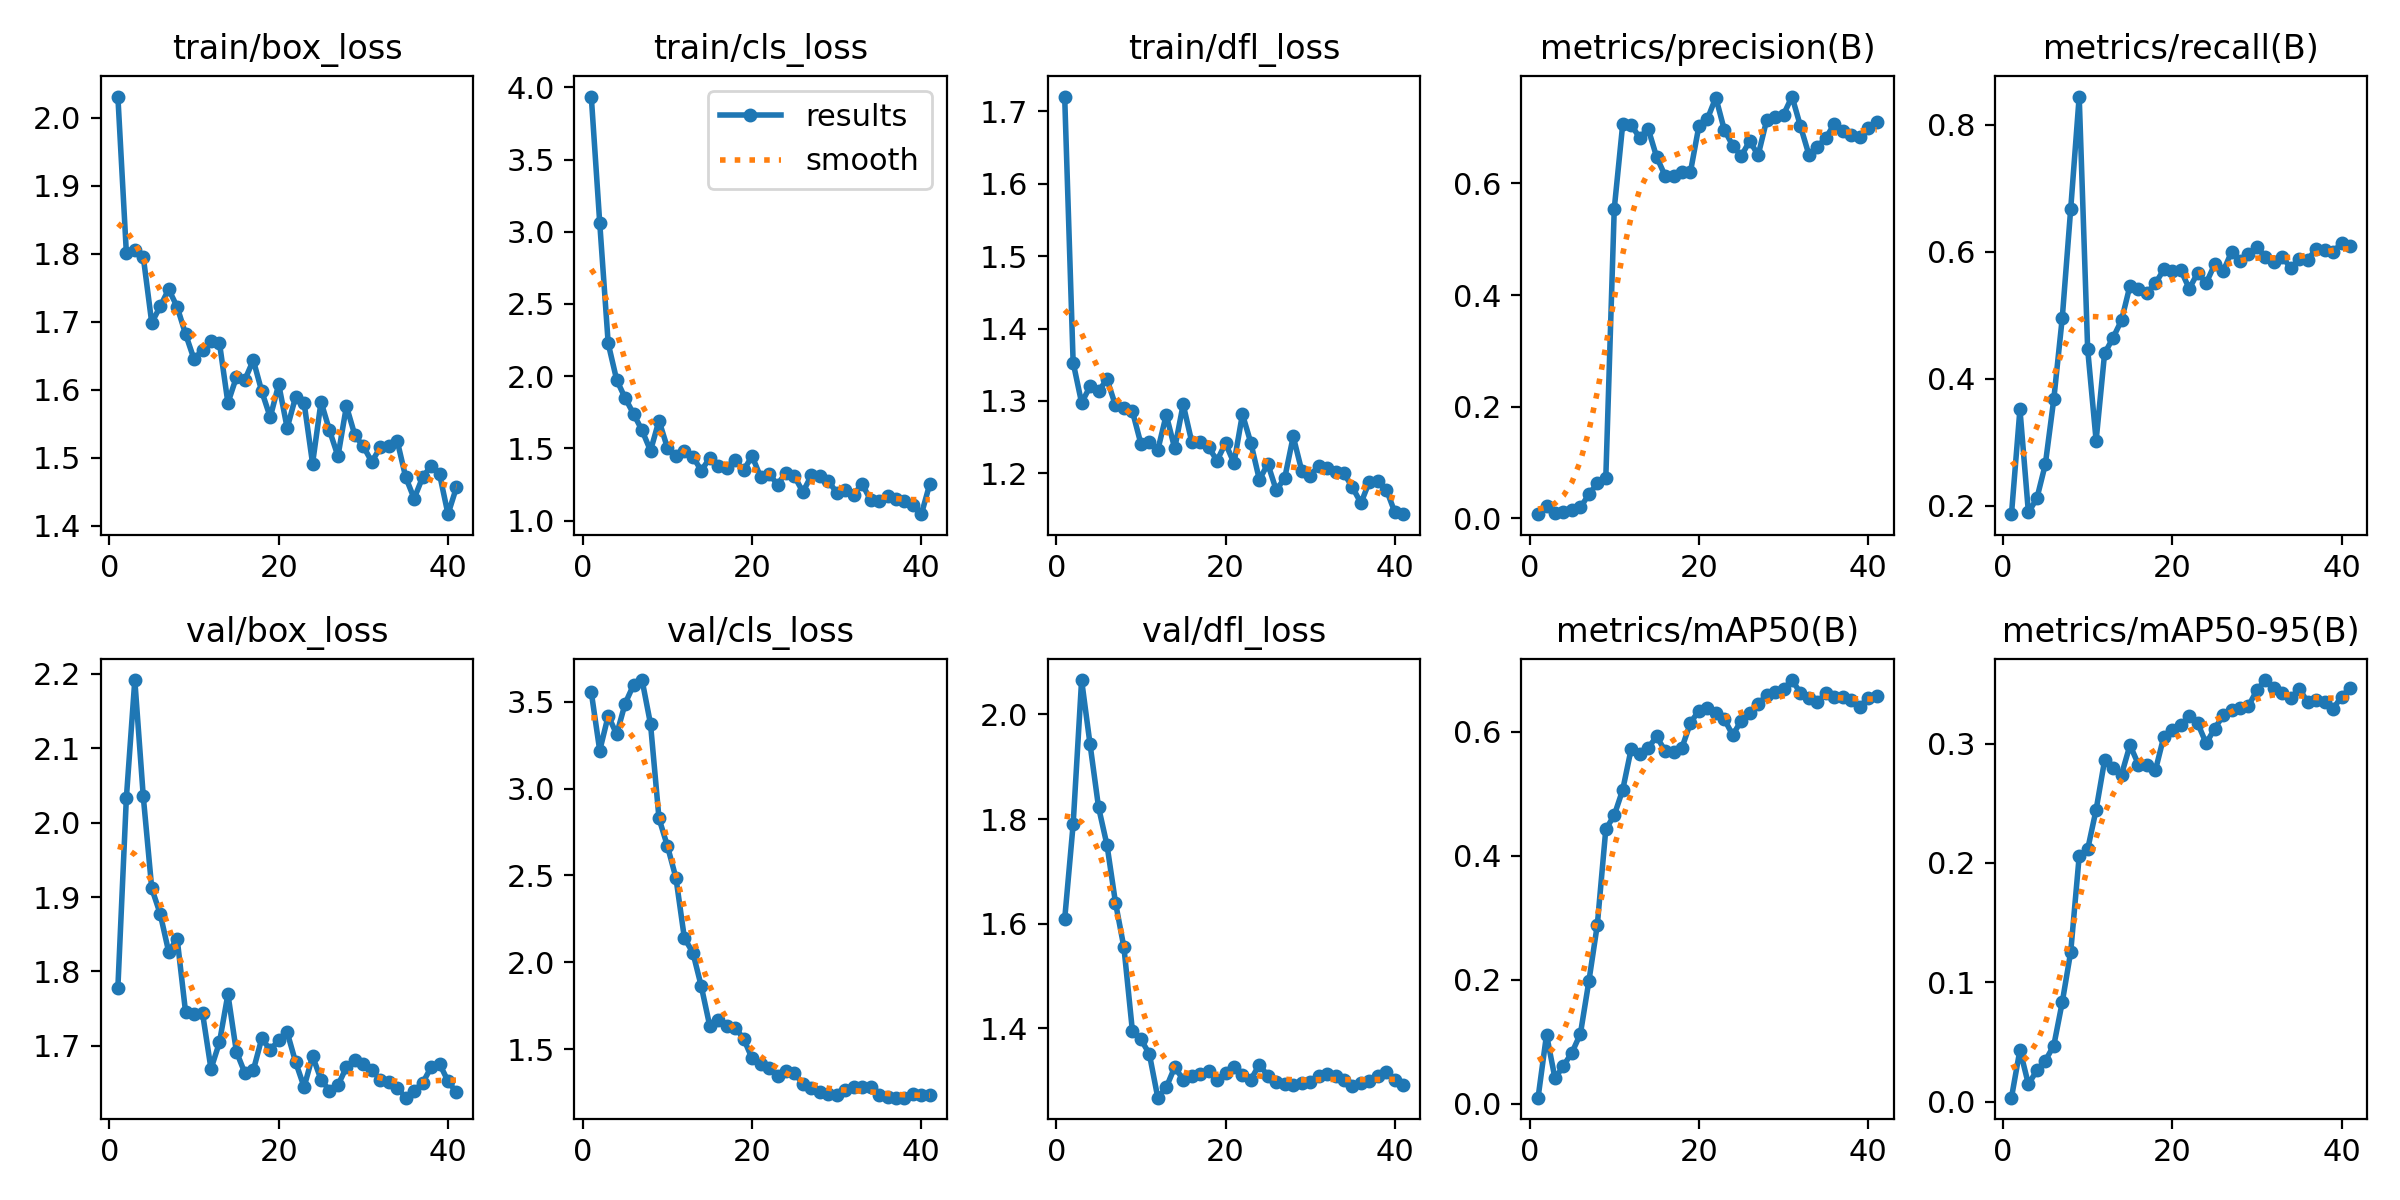

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/results.png', width=600)

/content


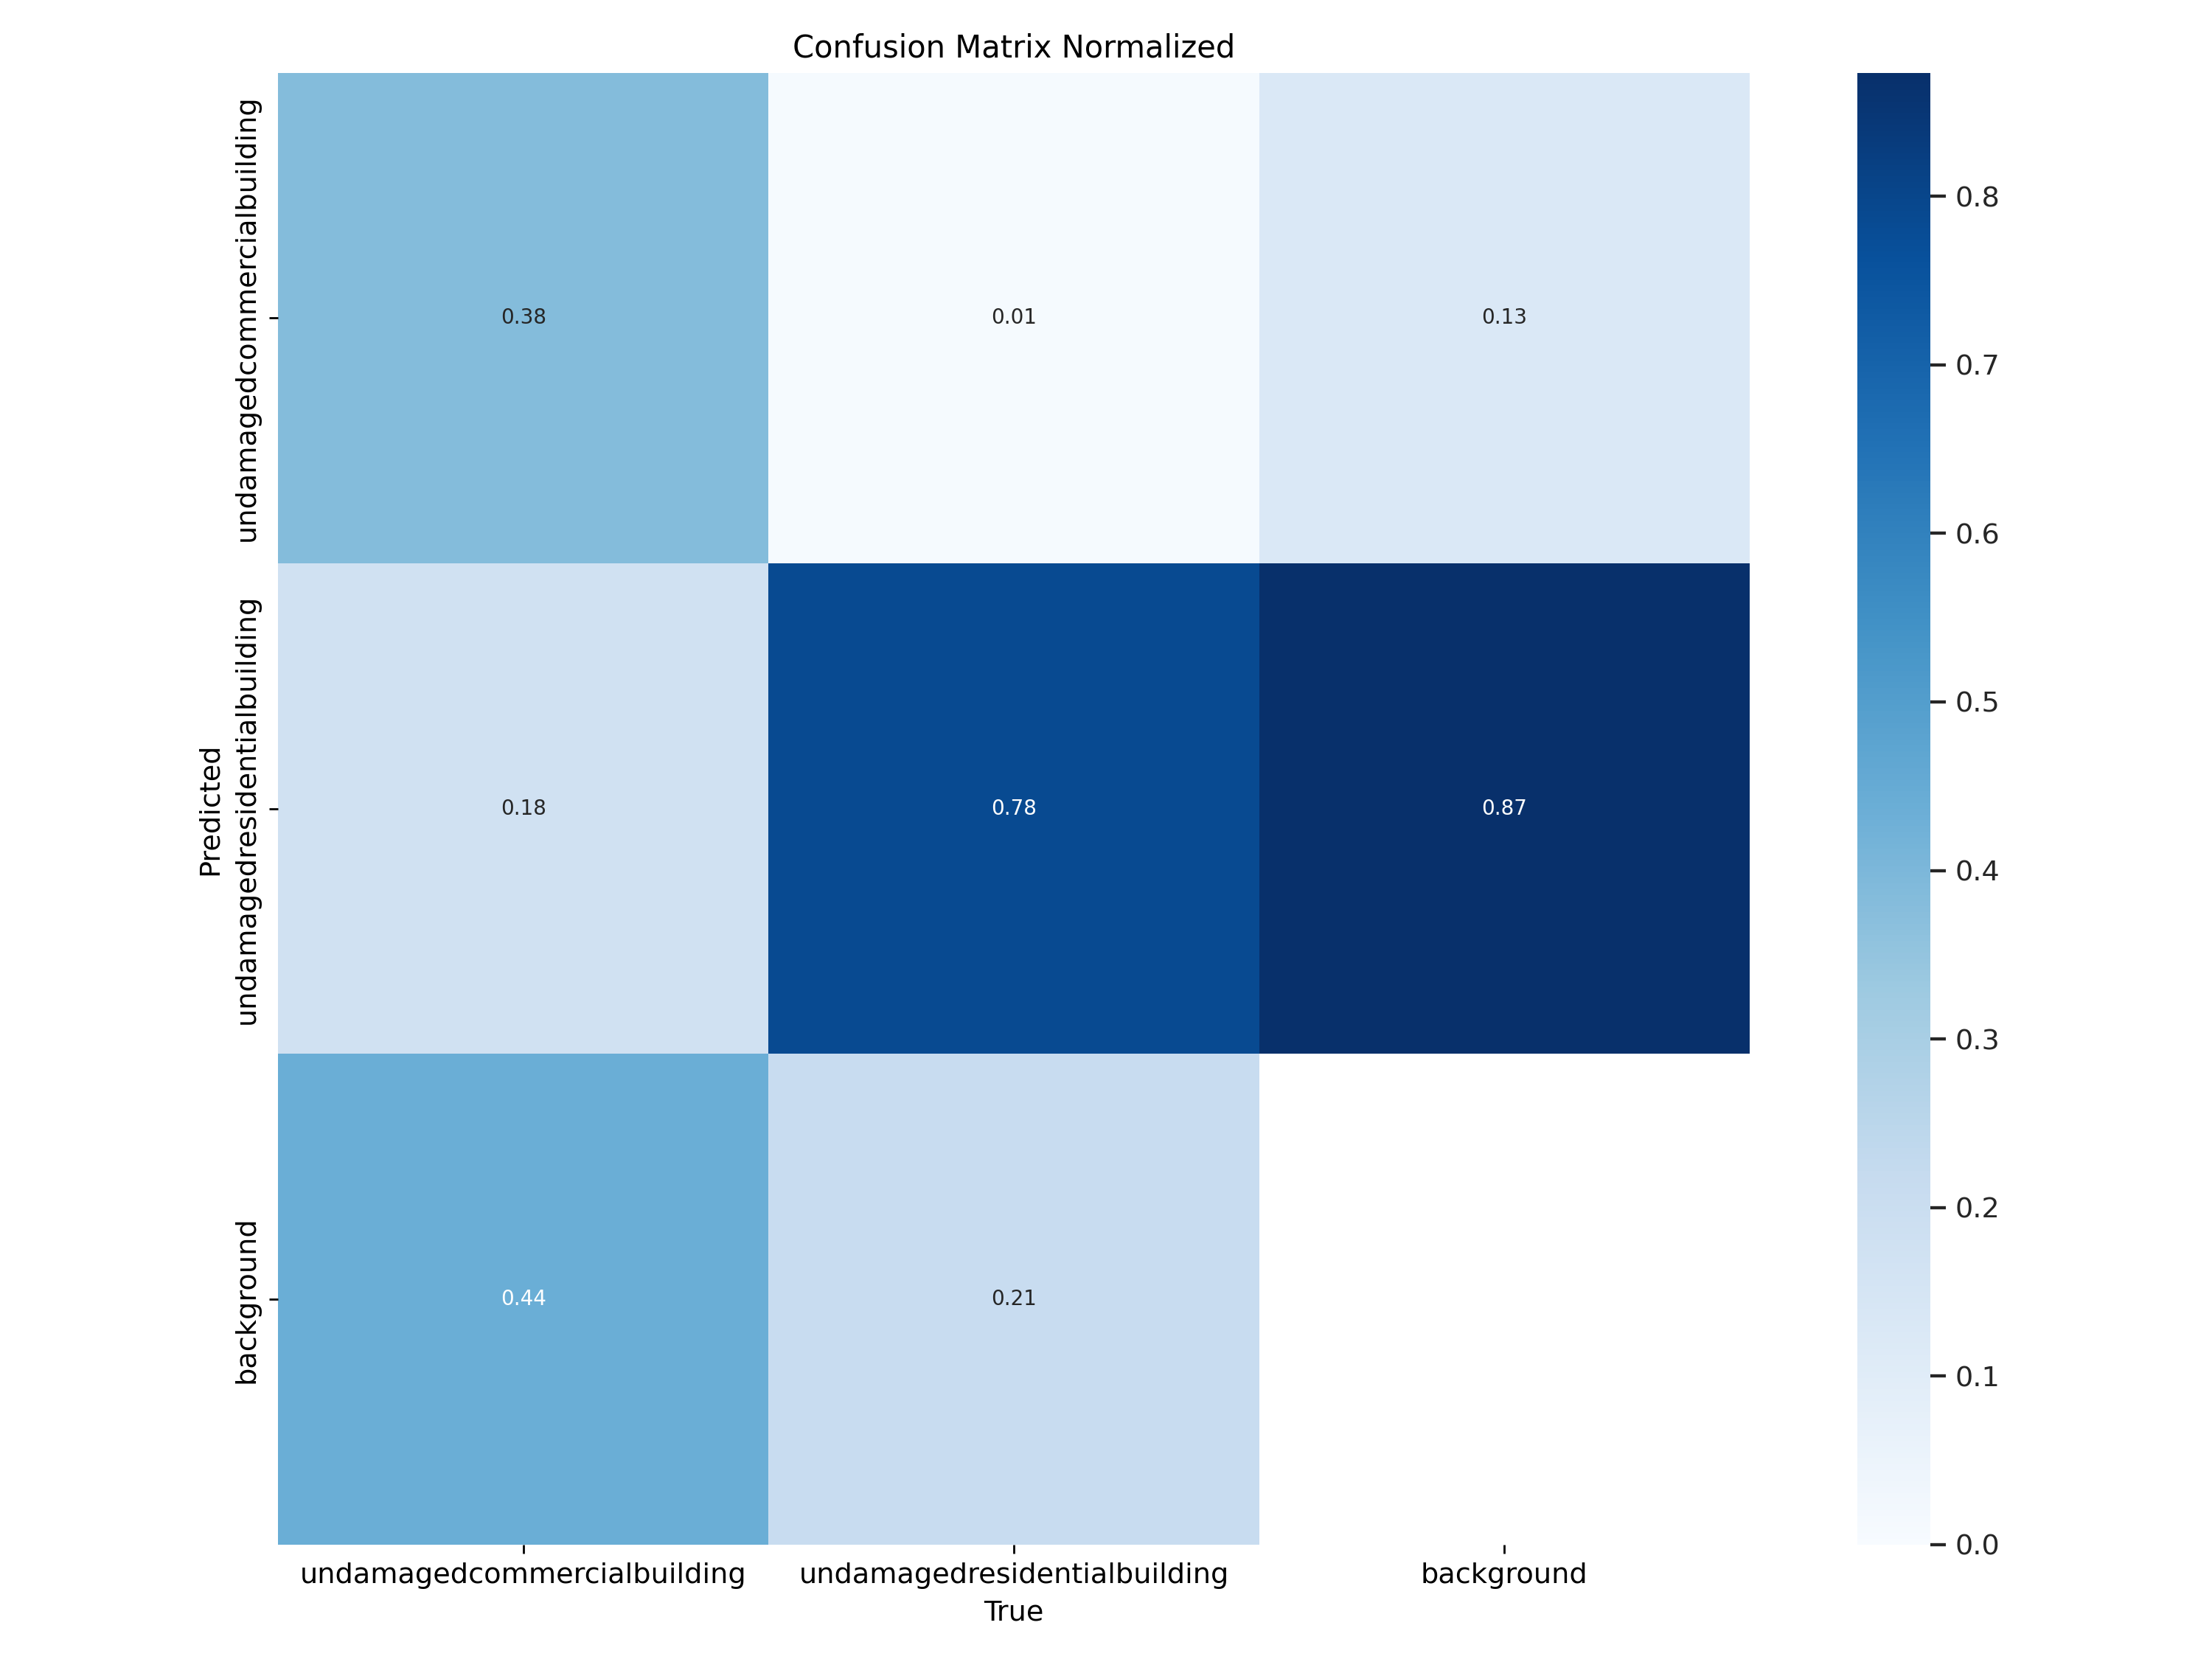

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/confusion_matrix_normalized.png', width=600)

### Dataset version 5:
Main characteristics: data augmentation on roboflow (3 steps)
batch = 16
lr0 = 5e-4,
momentum = 0.9,
'metrics/mAP50(B)': 0.6598689187019573, 'metrics/mAP50-95(B)': 0.342962345089014

/content


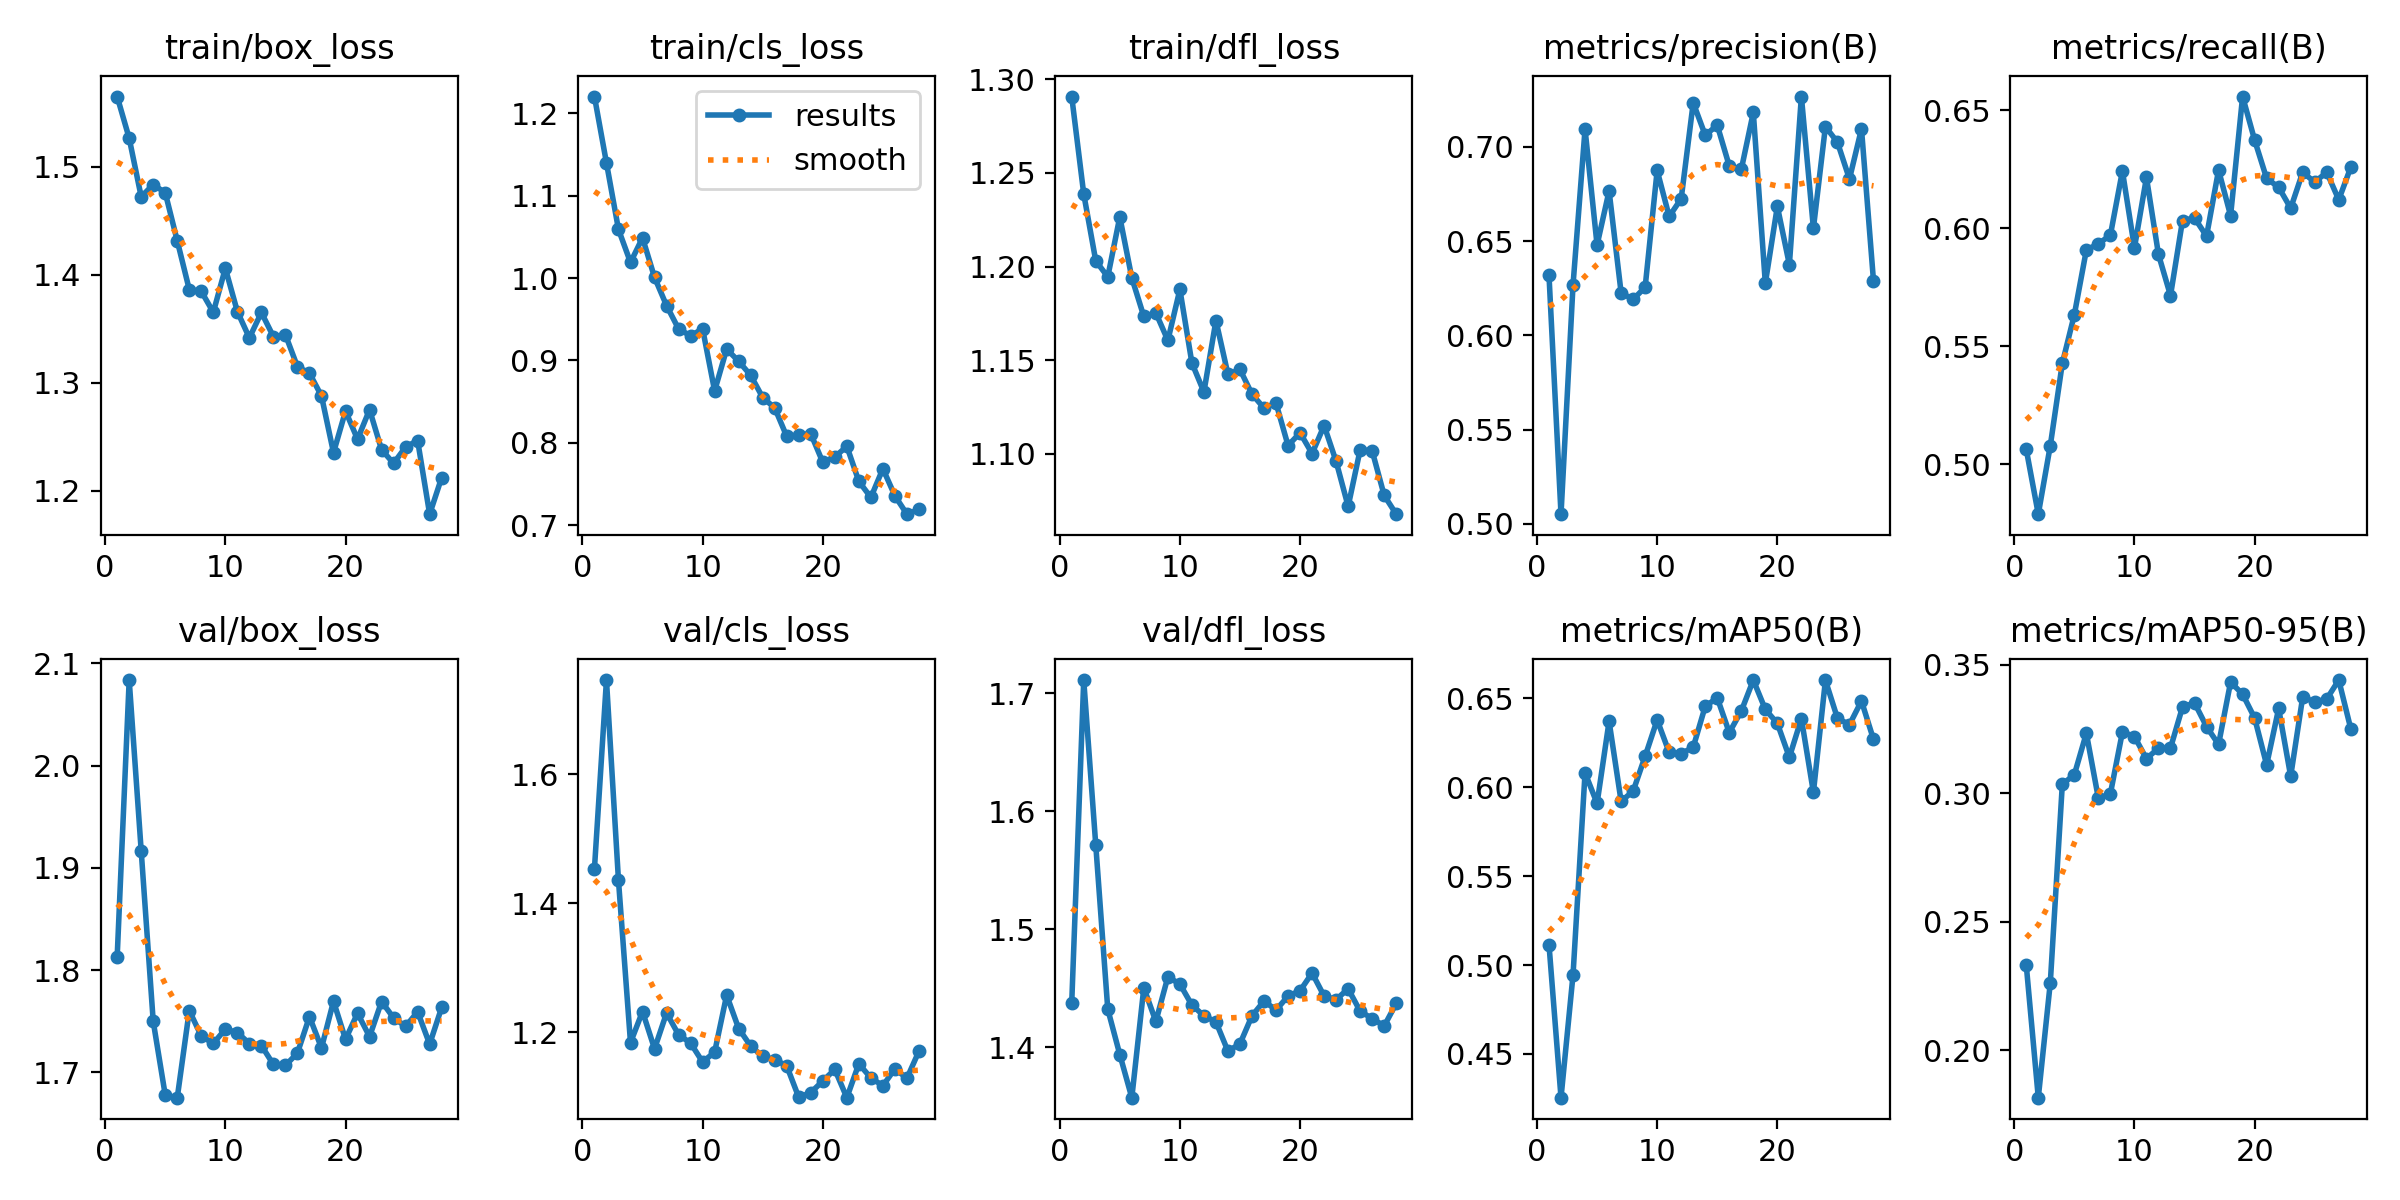

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}3/results.png', width=600)

/content


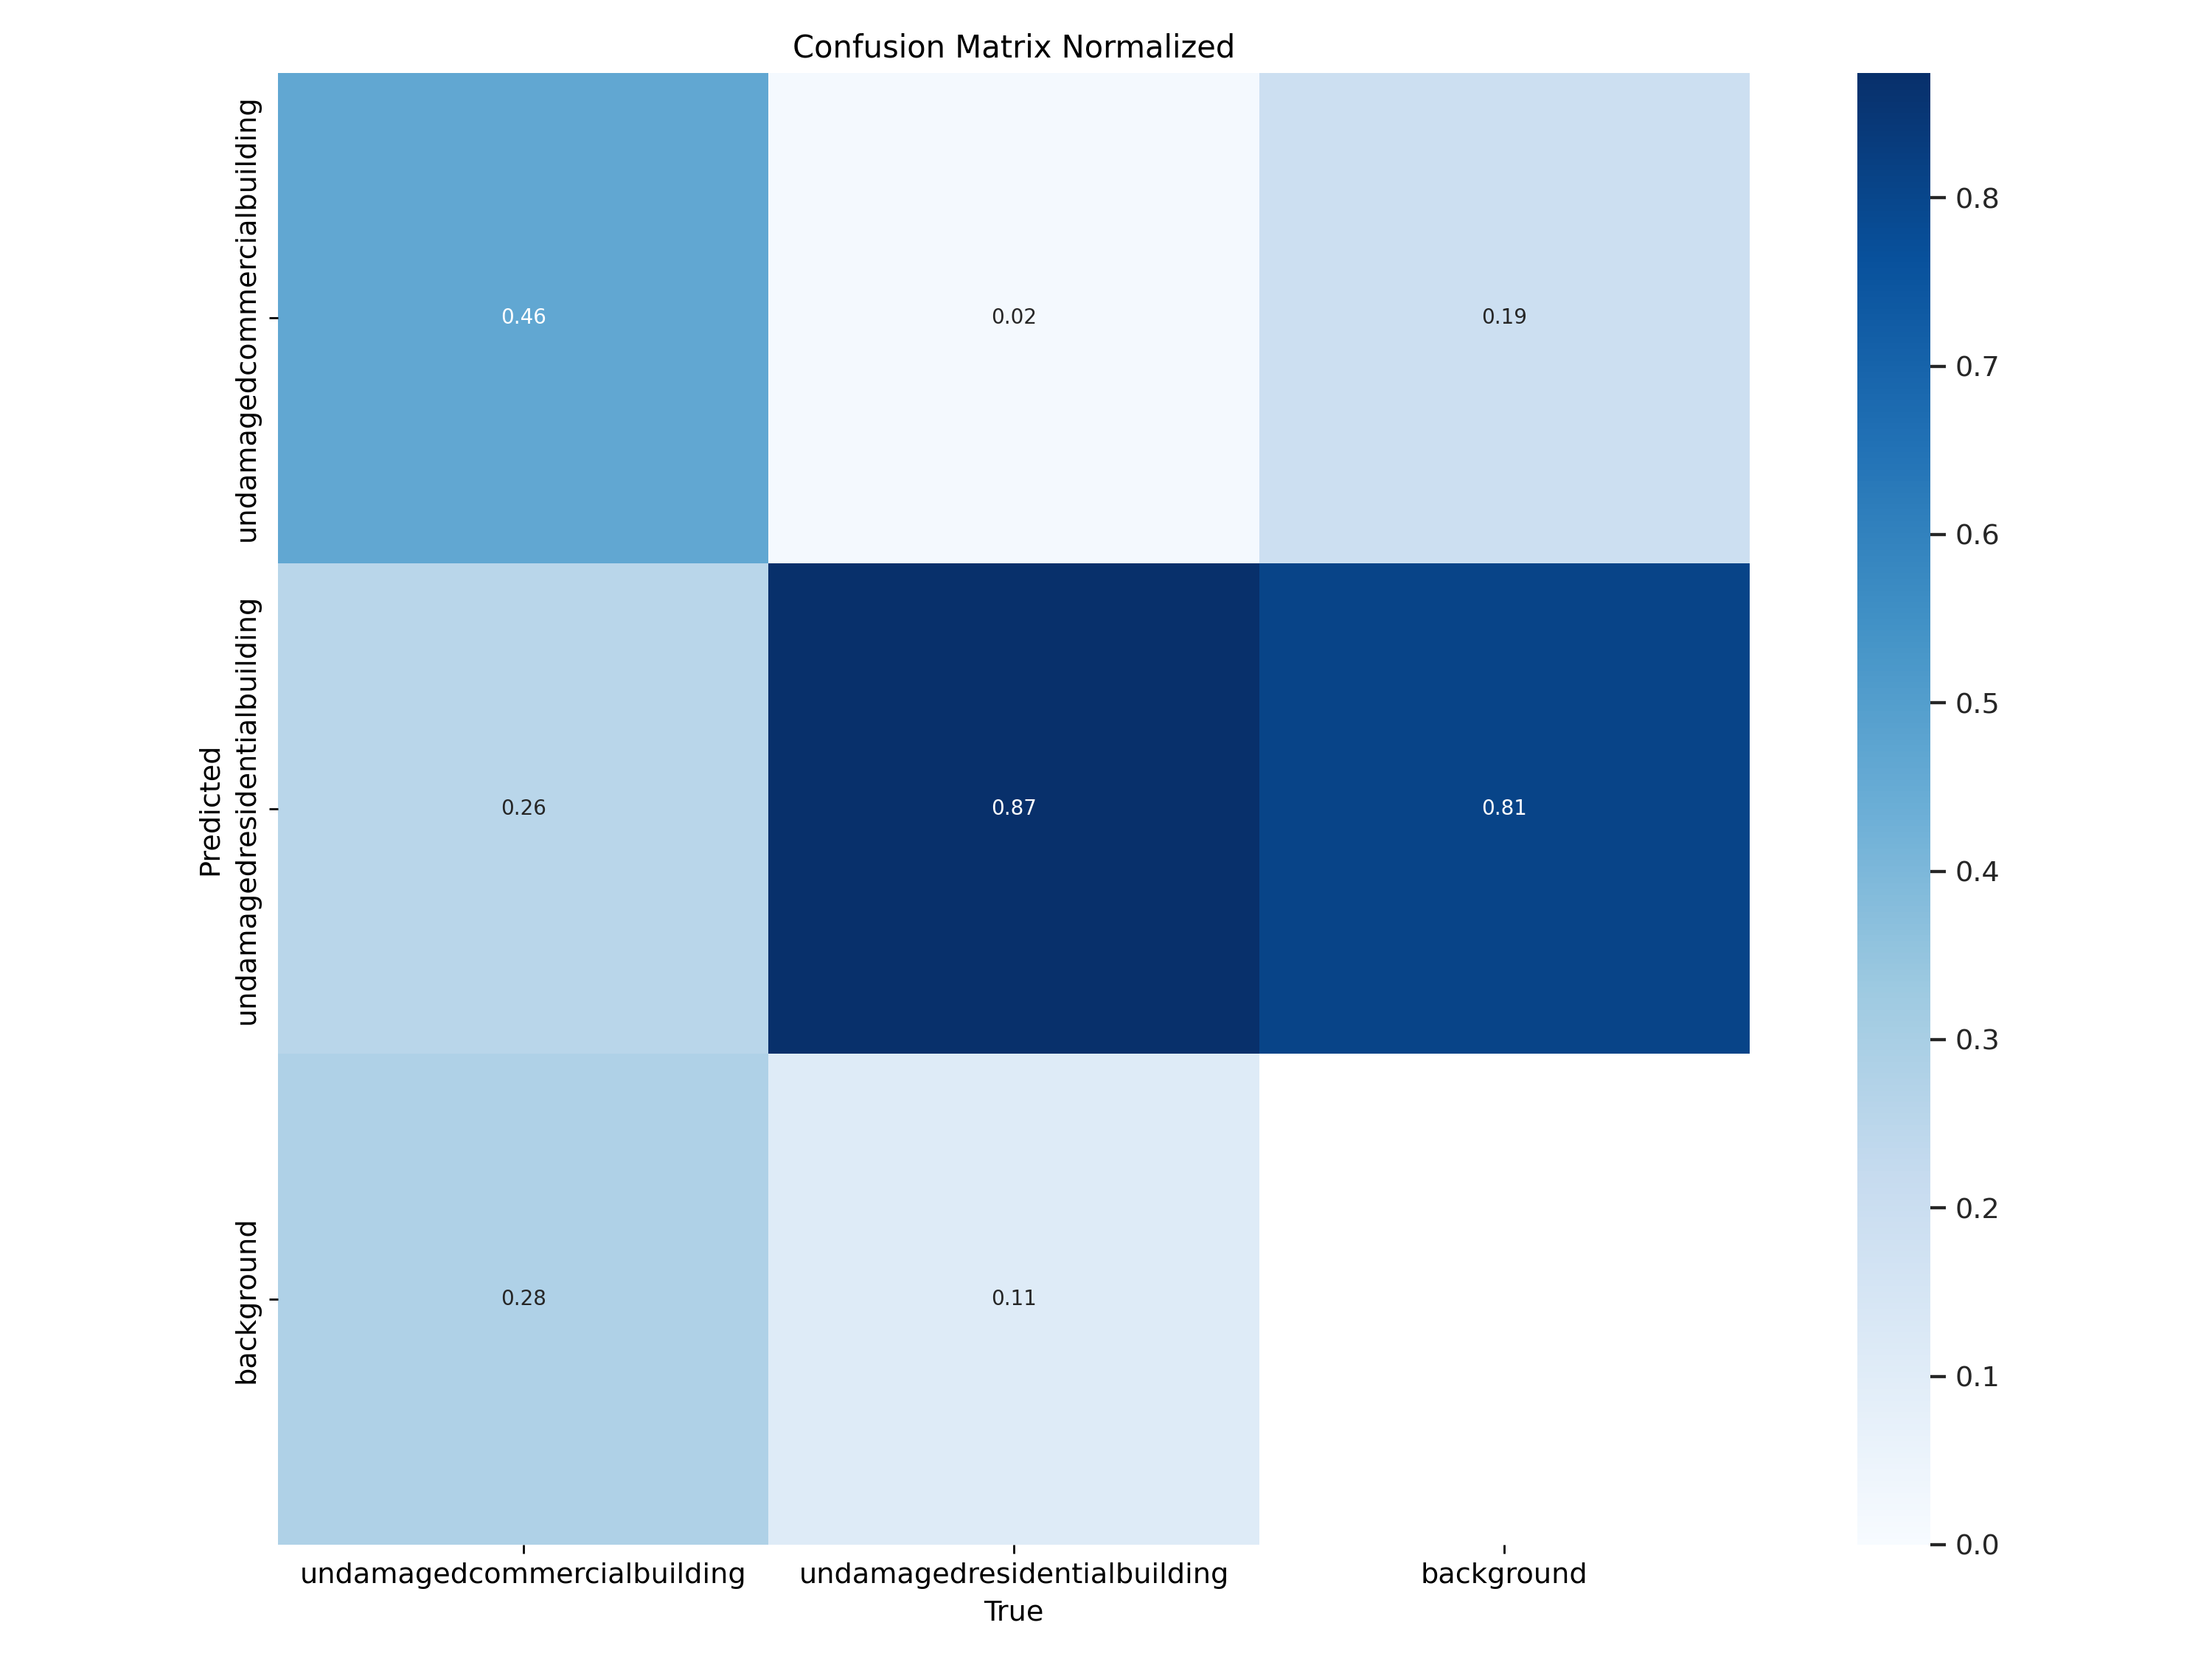

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}3/confusion_matrix_normalized.png', width=600)

## Testing the model performance on Test dataset

Ultralytics YOLOv8 doesn't have a separate mode=test option built-in, as it focuses on training and validation (i.e., mode=train and mode=val).

That being said, if you wish to evaluate your model on a test dataset, you can indeed do so by treating your test data as validation data. After finalizing your model from the validation stage, you can run your model on the test dataset using the mode='val'.

To do this, make sure your test dataset is in the appropriate format expected by YOLOv8. You can simply replace your /val split with your /test data when you're ready to perform testing. This way, you can use the validation mode to evaluate how your model performs on unseen data!

In [ ]:
# Load the model from the best training weights (Note: select path of the "best.pt" file)
path_to_weights_best = f"/{HOME}/{project}/{name_train}/weights/best.pt"
# /content/exploratory_phase/yolo11n_training_dataset_v4/weights/best.pt
model = YOLO(path_to_weights_best)

In [ ]:
# Evaluate model metrics on the "test" dataset split
split_test = 'test'
name_metrics_test = f'metrics_{split_test}' # Directory name for saving results
metrics_test = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split_test, project=project, name=name_metrics_test)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/Storm-Damage-4/test/labels... 20 images, 16 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 3071.63it/s]

val: New cache created: /content/Storm-Damage-4/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


                   all         20        174      0.645      0.658       0.63      0.335
undamagedcommercialbuilding          3          8      0.429       0.75      0.544       0.28
undamagedresidentialbuilding          4        166      0.862      0.566      0.716       0.39
Speed: 0.3ms preprocess, 20.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to exploratory_phase/metrics_test


In [ ]:
# Load the model from the best training weights
split_val = 'val'
name_metrics_val = f'metrics_{split_val}' # Directory name for saving results
# Run the selected model
metrics_val = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split_val, project=project, name=name_metrics_val)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/Storm-Damage-4/valid/labels.cache... 66 images, 20 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


                   all         66       1114      0.736      0.488      0.611      0.321
undamagedcommercialbuilding         33        204      0.627      0.338      0.477      0.268
undamagedresidentialbuilding         30        910      0.846      0.638      0.746      0.374
Speed: 0.5ms preprocess, 20.2ms inference, 0.0ms loss, 8.7ms postprocess per image
Results saved to exploratory_phase/metrics_val


In [ ]:
print(f"The model \'{model_version}{model_variant}\' trained on dataset \'{dataset_name}-version{dataset_version}\'")
print(f"Below, comparison of evaluation metrics on dataset splits \'{split_test}\' and \'{split_val}\'")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - mAP of each class: {metrics_test.box.maps}")
print(f"Val dataset - mAP of each class: {metrics_val.box.maps}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_test.box.map}")
print(f"Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_val.box.map}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_test.box.map50}")
print(f"Val dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_val.box.map50}")

The model '11n' trained on dataset 'storm-damage-version4'
Below, comparison of evaluation metrics on dataset splits 'test' and 'val'
--------------------------------------------------------------------------------
Test dataset - mAP of each class: [    0.27978     0.39024]
Val dataset - mAP of each class: [    0.26823     0.37427]
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.3350125324254318
Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.3212520205089856
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.6298291492460126
Val dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.6114151101434464


## Downloading Results (.zip file)

In [ ]:
from google.colab import files

# Define download parameters and file names
path_dir_to_zip = '/content/exploratory_phase/yolo11n_training_dataset_v4' #@param {type: "string"}
output_filename = 'yolo11n_training_dataset_v4.zip' #@param {type: "string"}
path_zip_file = f'{HOME}/{output_filename}'
delete_zip_file_after_download = "No"  #@param ['Yes', 'No']

os.system("zip -r {} {}".format(output_filename, path_dir_to_zip))
# Download file to local machine
files.download(output_filename)
# Delete the created zip file (optional)
if delete_zip_file_after_download == "Yes":
    os.system("rm -r {}".format(path_zip_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Draft Code (not important)

## Loading Training Datasets

Mound google drive which contains the required training dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Check internet speed (optional)

In [ ]:
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.126.168.143)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by PT. Jala Lintas Media (Semarang) [1171.81 km]: 30.175 ms
Testing download speed................................................................................
Download: 263.09 Mbit/s
Testing upload speed......................................................................................................
Upload: 184.19 Mbit/s


Print the current working directory in google collab

In [ ]:
!pwd

/content


Create a new directory for the dataset

In [ ]:
!mkdir data

In [ ]:
!cp -r ../gdrive/MyDrive/Colab\ Notebooks/datasets/hurricanedamagev7.v2i.yolov8.train.valid /content/data

Copy the whole directory with results to a connected google drive

In [ ]:
!scp -r /content/runs /content/gdrive/My Drive/ComputerVision/TrainingResults # adapt to own folder name